In [123]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import glob
import gc
import string
from unicodedata import normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import shuffle

from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
from imblearn.under_sampling import AllKNN

import tensorflow as tf
from keras.models import Model
from keras.layers import Layer
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Concatenate
from keras.layers import Lambda
from keras.models import load_model
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import nltk
from nltk.tokenize import RegexpTokenizer
import spacy


In [124]:
#Variável que será usada para selecionar o tipo de dados que será usado
#Dois valores possíveis:  stem ou lemman
#se stem : dados com stemming
#se lemman: dados com lemmantizacao
stem_or_lemman=None
while stem_or_lemman!='stem' and stem_or_lemman!='lemman':
    stem_or_lemman=input("Digite o tipo de pré-processamento que será aplicado aos comentários (stem ou lemman):")
    if stem_or_lemman=='lemman' or stem_or_lemman=='stem':
        break
    else:
       print("Entrada inválida. As opções aceitas são 'stem' ou 'lemman'")

# Carregar Dados

In [125]:
files=glob.glob('../archive/*.csv')
files

['../archive/parque_nacional_iguacu.csv',
 '../archive/parque_chapada_dos_veadeiros.csv',
 '../archive/museu_imperial.csv',
 '../archive/mercado-central-fortaleza-ce.csv',
 '../archive/jardim_botanico.csv',
 '../archive/aqua-rio-rj.csv',
 '../archive/mercado-ver-o-peso-pa.csv',
 '../archive/praia-copacabana-rj.csv',
 '../archive/elevador_lacerda.csv',
 '../archive/pelourinho_ba.csv',
 '../archive/museu_arte_sp.csv',
 '../archive/praca-3-poderes-br.csv',
 '../archive/parque_jalapao.csv',
 '../archive/hopi_hari.csv',
 '../archive/beto-carreiro-sc.csv']

In [126]:
#dados será um dicionário com os comentários e as notas de cada usuário
# as chaves do dicionário serão os nomes dos destinos turísticos

dados={}

for file in files:
    dados[file.split('/')[-1].split('.')[0]]=pd.read_csv(file, delimiter=';')



In [127]:
dados.keys()
nomes_destinos=list(dados.keys())

In [128]:
print('Destinos turísticos avaliados:')
print('')
for nome_destino in nomes_destinos:
    print(nome_destino)

Destinos turísticos avaliados:

parque_nacional_iguacu
parque_chapada_dos_veadeiros
museu_imperial
mercado-central-fortaleza-ce
jardim_botanico
aqua-rio-rj
mercado-ver-o-peso-pa
praia-copacabana-rj
elevador_lacerda
pelourinho_ba
museu_arte_sp
praca-3-poderes-br
parque_jalapao
hopi_hari
beto-carreiro-sc


# Análise Exploratória - Notas

## Comparativo entre as notas dos destinos turísticos

'''
Nessa seção será feito um comparativo entre as avaliações (somente das notas) recebidas por cada uma das atrações.
As atrações foram avaliadas com notas variando entre 1 e 5, sendo 5 a melhor nota.
'''

In [129]:
#Verificando a existência de entradas nulas
print('Número de entradas nulas para as notas das atrações:')
print('')
for nome in nomes_destinos:
    print(nome+ ' : {}'.format(dados[nome]['nota'].isnull().sum()))

Número de entradas nulas para as notas das atrações:

parque_nacional_iguacu : 0
parque_chapada_dos_veadeiros : 0
museu_imperial : 0
mercado-central-fortaleza-ce : 0
jardim_botanico : 0
aqua-rio-rj : 0
mercado-ver-o-peso-pa : 0
praia-copacabana-rj : 0
elevador_lacerda : 0
pelourinho_ba : 0
museu_arte_sp : 0
praca-3-poderes-br : 0
parque_jalapao : 0
hopi_hari : 0
beto-carreiro-sc : 0


### Nota média de cada destino turistico

In [130]:
dados_nota_media={}
for destino in nomes_destinos:
    dados_nota_media[destino]=dados[destino]['nota'].mean()
dados_nota_media=pd.DataFrame.from_dict(dados_nota_media,orient='index').rename(columns={0:'Nota_Média'}).sort_values(by='Nota_Média',ascending=False)
dados_nota_media.index.rename('Destino',inplace=True)
dados_nota_media

,Nota_Média
Destino,
parque_nacional_iguacu,4.837884
parque_chapada_dos_veadeiros,4.788469
parque_jalapao,4.781955
museu_imperial,4.655708
jardim_botanico,4.628761
museu_arte_sp,4.554544
praia-copacabana-rj,4.371347
praca-3-poderes-br,4.250324
aqua-rio-rj,4.127649


<Axes: title={'center': 'Nota média de cada destino'}, xlabel='Destino', ylabel='Nota_Média'>

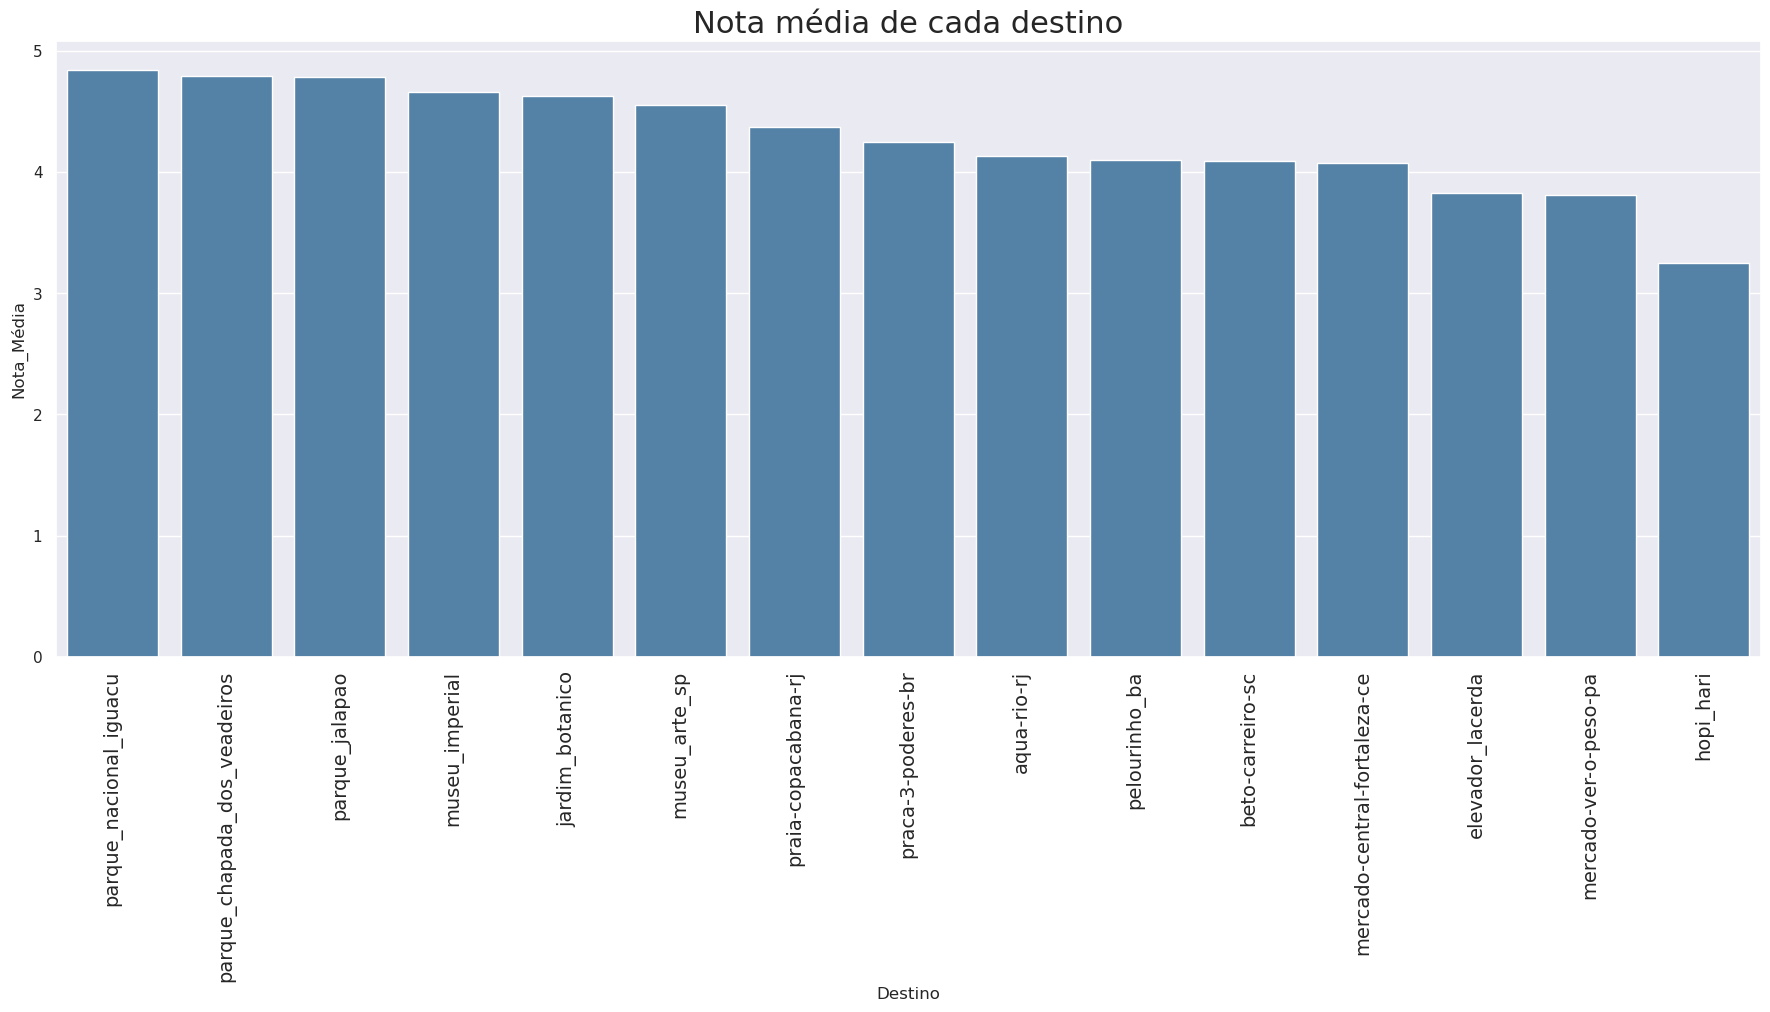

In [131]:
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.title('Nota média de cada destino',fontsize = 22)
plt.xticks(rotation=90,fontsize=14)
sns.barplot(dados_nota_media,x=dados_nota_media.index,y='Nota_Média',color='steelblue')



### Proporção de avaliações com cada nota para cada destino turístico

In [132]:
#Calcular a proporção das notas em relação ao número de avaliações
proporcao_notas=[]
for destino in nomes_destinos:
    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))
    proporcao_notas+=[[(dados[destino]['nota']==nota).sum() for nota in [1,2,3,4,5]]]
proporcao_notas=pd.DataFrame(proporcao_notas,index=nomes_destinos)
proporcao_notas["Total Avaliações"]=proporcao_notas.sum(axis=1)
proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
proporcao_notas.columns=   ['nota 1(%)',
                            'nota 2(%)',
                            'nota 3(%)',
                            'nota 4(%)',
                            'nota 5(%)',
                             "Total Avaliações"]

/tmp/ipykernel_5218/3708725821.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'parque_nacional_iguacu          0.001532
parque_chapada_dos_veadeiros    0.002203
museu_imperial                  0.002822
mercado-central-fortaleza-ce    0.012190
jardim_botanico                 0.001403
aqua-rio-rj                     0.025720
mercado-ver-o-peso-pa           0.046576
praia-copacabana-rj             0.011091
elevador_lacerda                0.026991
pelourinho_ba                   0.024637
museu_arte_sp                   0.004138
praca-3-poderes-br              0.006485
parque_jalapao                  0.000000
hopi_hari                       0.164688
beto-carreiro-sc                0.093956
Name: 0, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
/tmp/ipykernel

In [133]:
#O dataframe proporcao_notas exibe o total de avaliações de cada destino turístico e a proporção desse total correspondentes as
#notas 1,2,3,4 e 5
proporcao_notas

,nota 1(%),nota 2(%),nota 3(%),nota 4(%),nota 5(%),Total Avaliações
parque_nacional_iguacu,0.001532,0.001892,0.011715,0.126881,0.857980,11097
parque_chapada_dos_veadeiros,0.002203,0.003672,0.021667,0.148366,0.824091,2723
museu_imperial,0.002822,0.005080,0.034994,0.247778,0.709327,7087
mercado-central-fortaleza-ce,0.012190,0.028059,0.194112,0.402254,0.363385,4348
jardim_botanico,0.001403,0.003724,0.050498,0.253458,0.690916,20674
aqua-rio-rj,0.025720,0.048583,0.150750,0.322220,0.452727,4199
mercado-ver-o-peso-pa,0.046576,0.079845,0.222345,0.319379,0.331855,3607
praia-copacabana-rj,0.011091,0.023617,0.117563,0.278314,0.569415,7664
elevador_lacerda,0.026991,0.064808,0.278066,0.317959,0.312176,6743
pelourinho_ba,0.024637,0.040003,0.165692,0.352347,0.417321,11974


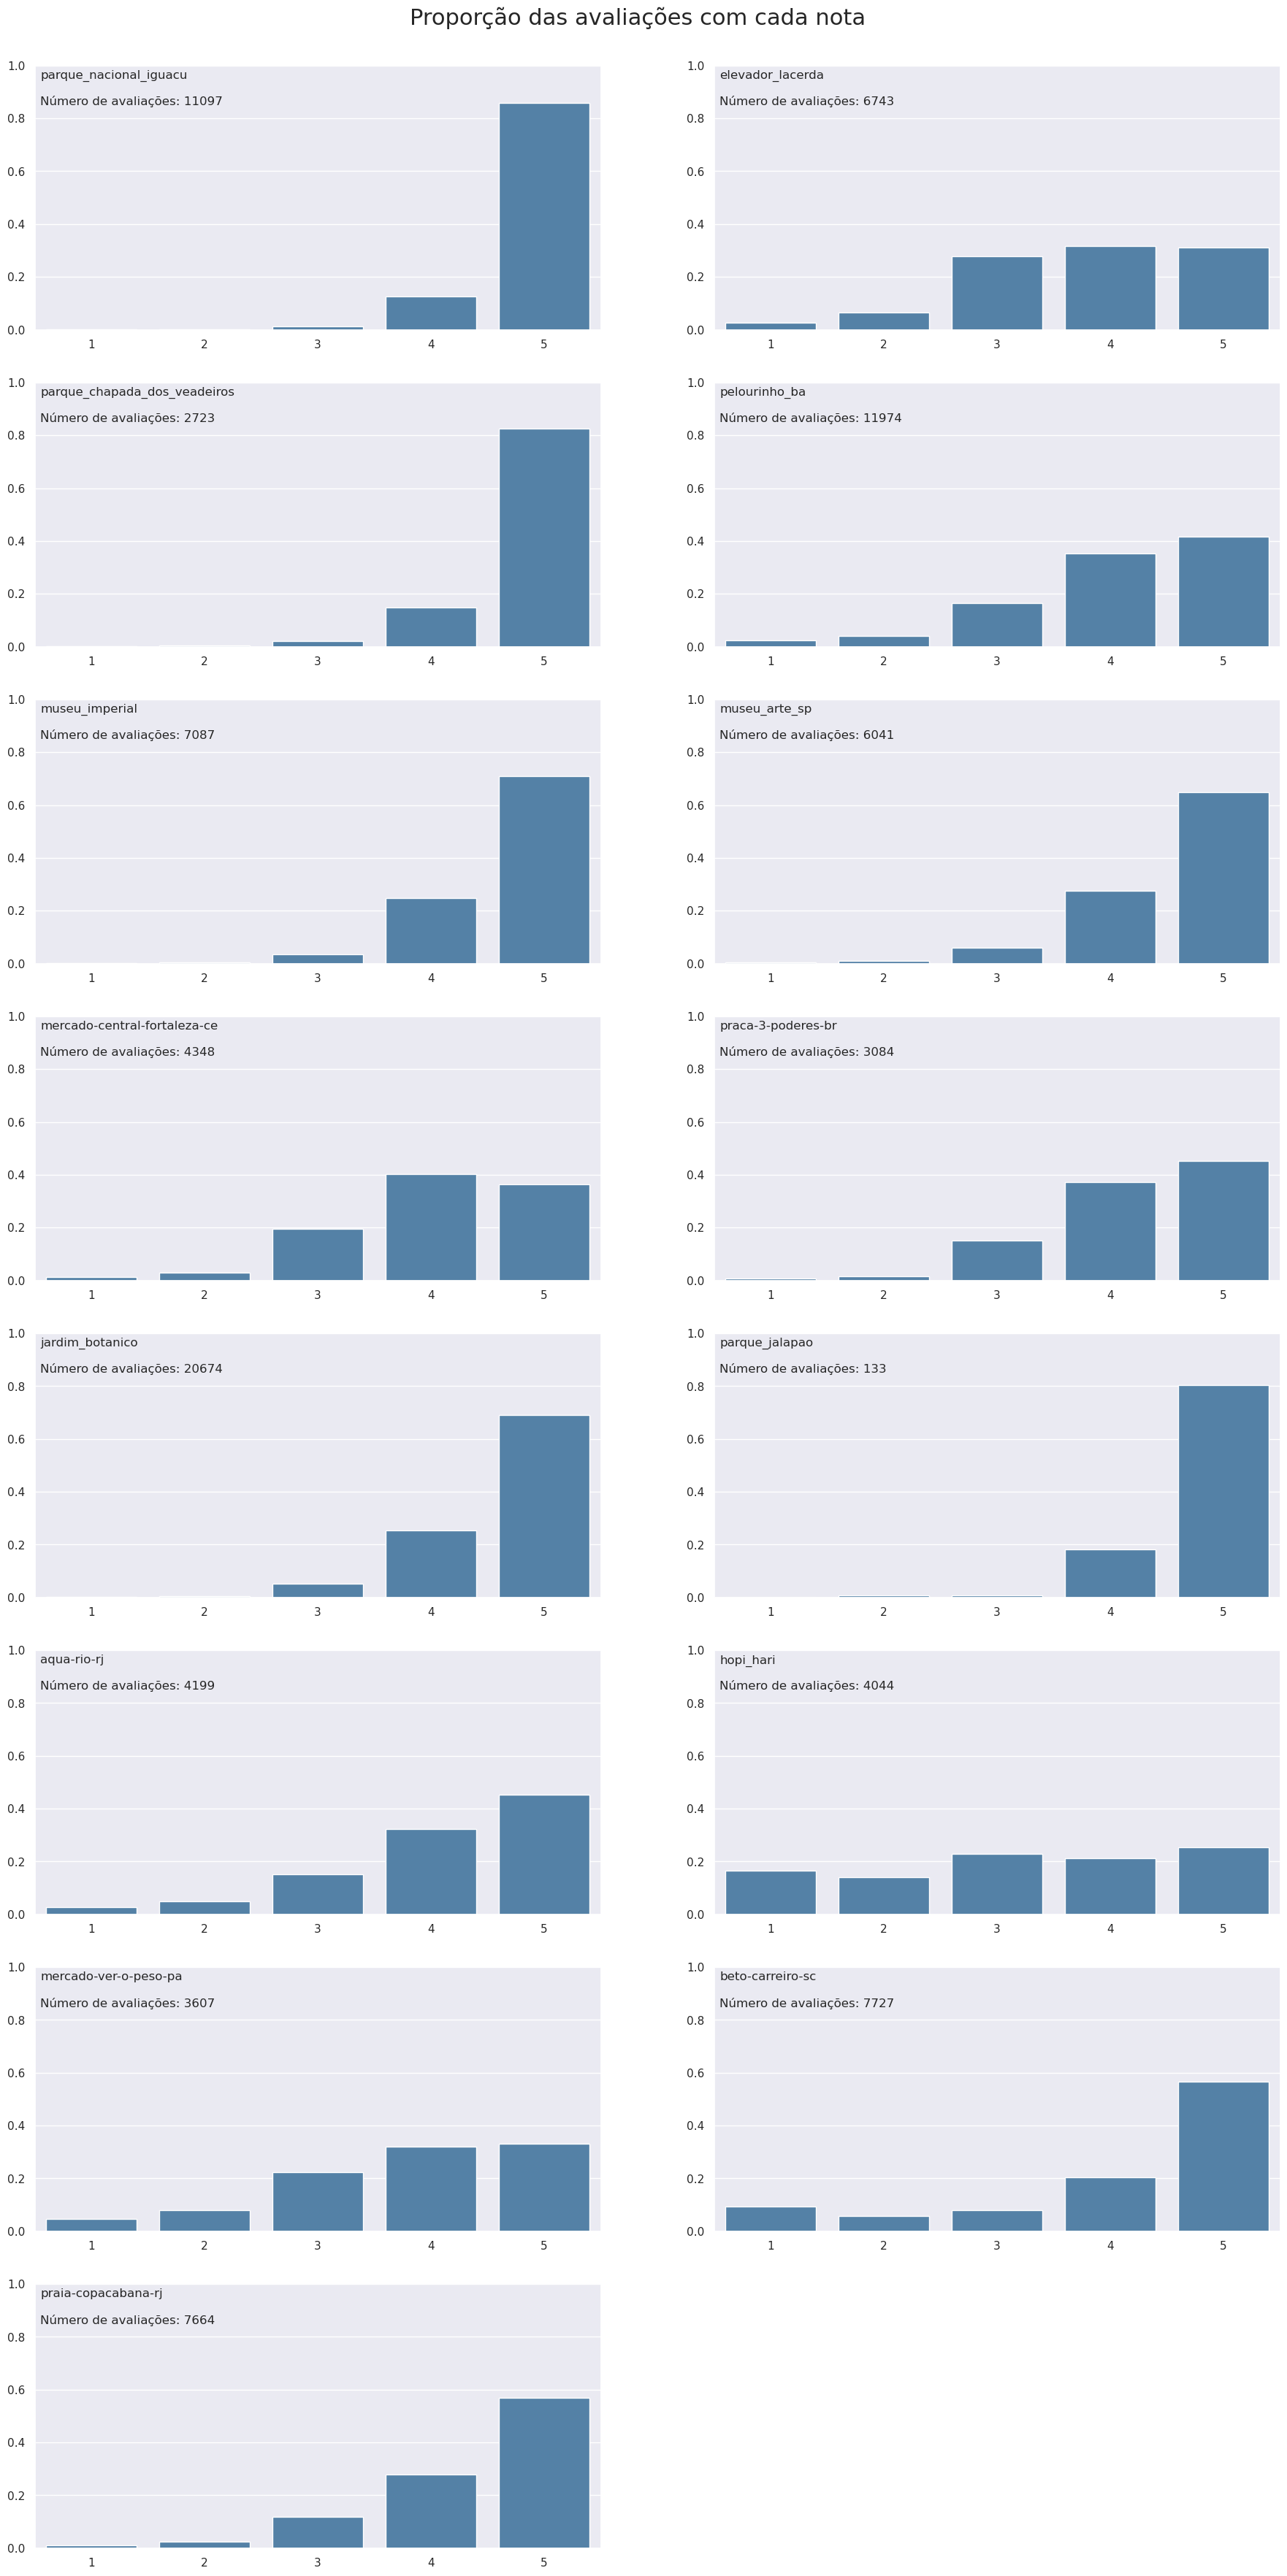

In [134]:
#Plotar graficos com as proporções das avaliações para cada destino
fig,axs=plt.subplots(8,2,figsize=(22,40))
plt.subplots_adjust(top=0.96) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Proporção das avaliações com cada nota', fontsize=22) #adiciona um título geral para os subplots
row_subplot=0
col_subplot=0
for num_destino in range(len(proporcao_notas)):
    destino=proporcao_notas.index[num_destino]
    sns.set_theme(style='darkgrid')
    ax=sns.barplot(x=[1,2,3,4,5],y=proporcao_notas.iloc[num_destino,:5],ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, destino)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(proporcao_notas.loc[destino,'Total Avaliações']))
    ax.set(ylabel=None)
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])


### Proporção de avaliações positivas, negativas e neutras

In [135]:
#Criação de dataframe com proporção de avaliações negativas, neutras e positivas

#Avaliação negativa - notas 1 e 2
#Avaliação neutra   - nota 3
#Avaliação positiva - notas 4 e 5


pos_neutra_neg=pd.concat((proporcao_notas.iloc[:,:2].sum(axis=1),
                          proporcao_notas.iloc[:,2],
                          proporcao_notas.iloc[:,3:5].sum(axis=1)),axis=1)
pos_neutra_neg.columns=['Negativas(%)',
                        'Neutras(%)',
                        'Positivas(%)']

pos_neutra_neg.sort_values(by=['Positivas(%)'],ascending=False,inplace=True)
pos_neutra_neg.index.rename('Destino',inplace=True)

[[<matplotlib.axis.YTick at 0x7ff88a4bea90>,

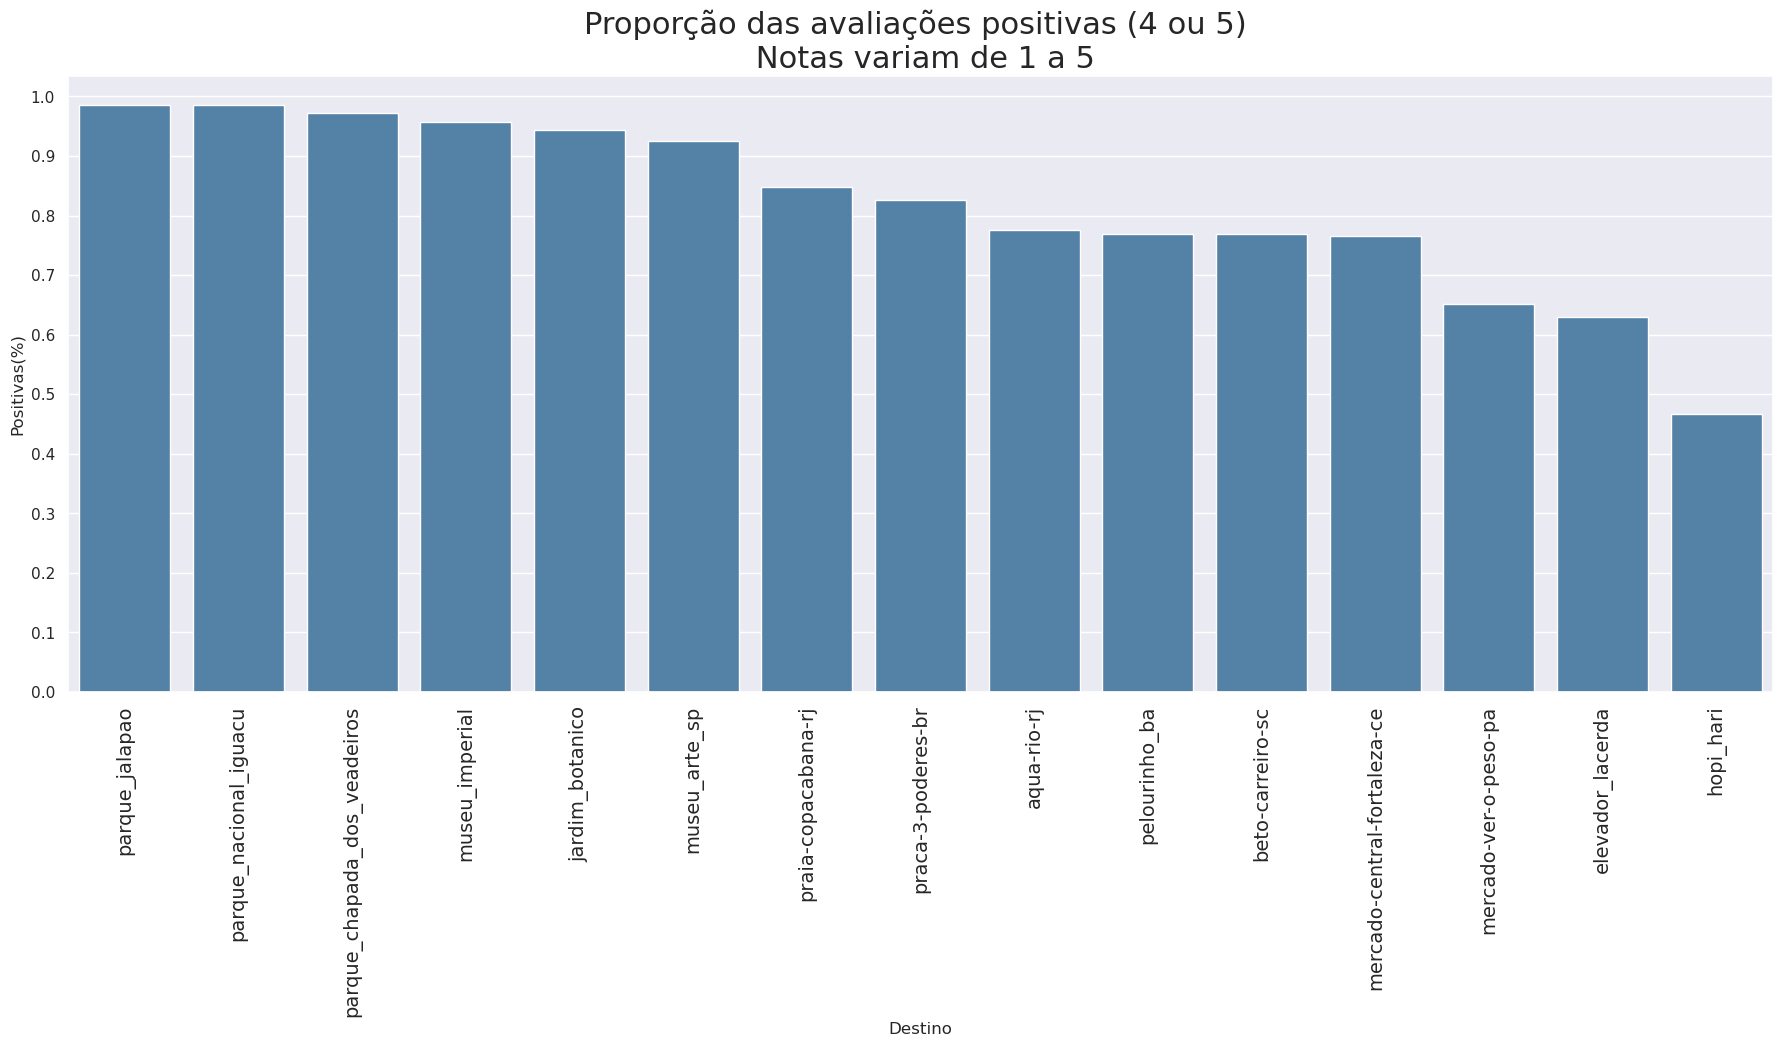

In [136]:
# Criação de gráfico para comparação entre a proporção das avaliações positivas
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações positivas (4 ou 5) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Positivas(%)'],ascending=False,inplace=True),x=pos_neutra_neg.index,y=pos_neutra_neg['Positivas(%)'],color='steelblue')
g.set(yticks=np.arange(0,1.1,0.1))


[[<matplotlib.axis.YTick at 0x7ff88a39b0d0>,

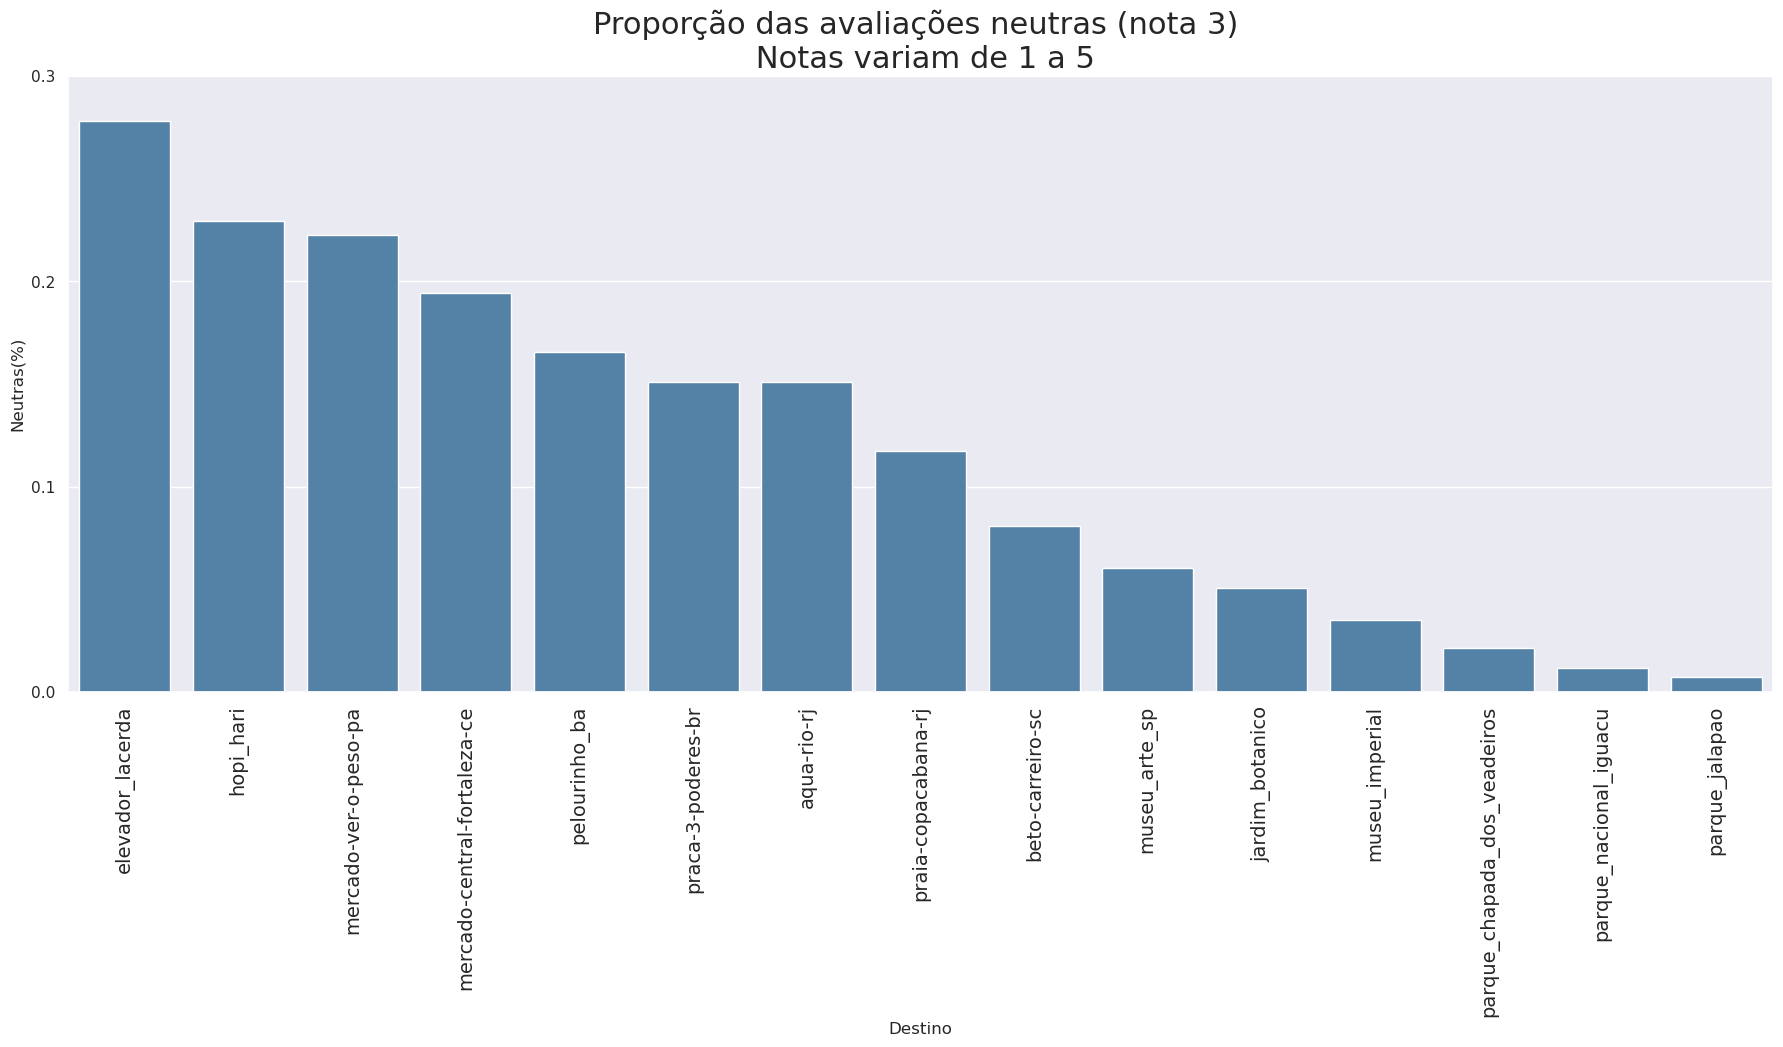

In [137]:
# Criação de gráfico para comparação entre a proporção das avaliações neutras
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações neutras (nota 3) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Neutras(%)'],ascending=False,inplace=True),x=pos_neutra_neg.index,
              y=pos_neutra_neg['Neutras(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.4,0.1))


Text(0.5, 0, 'Destino')

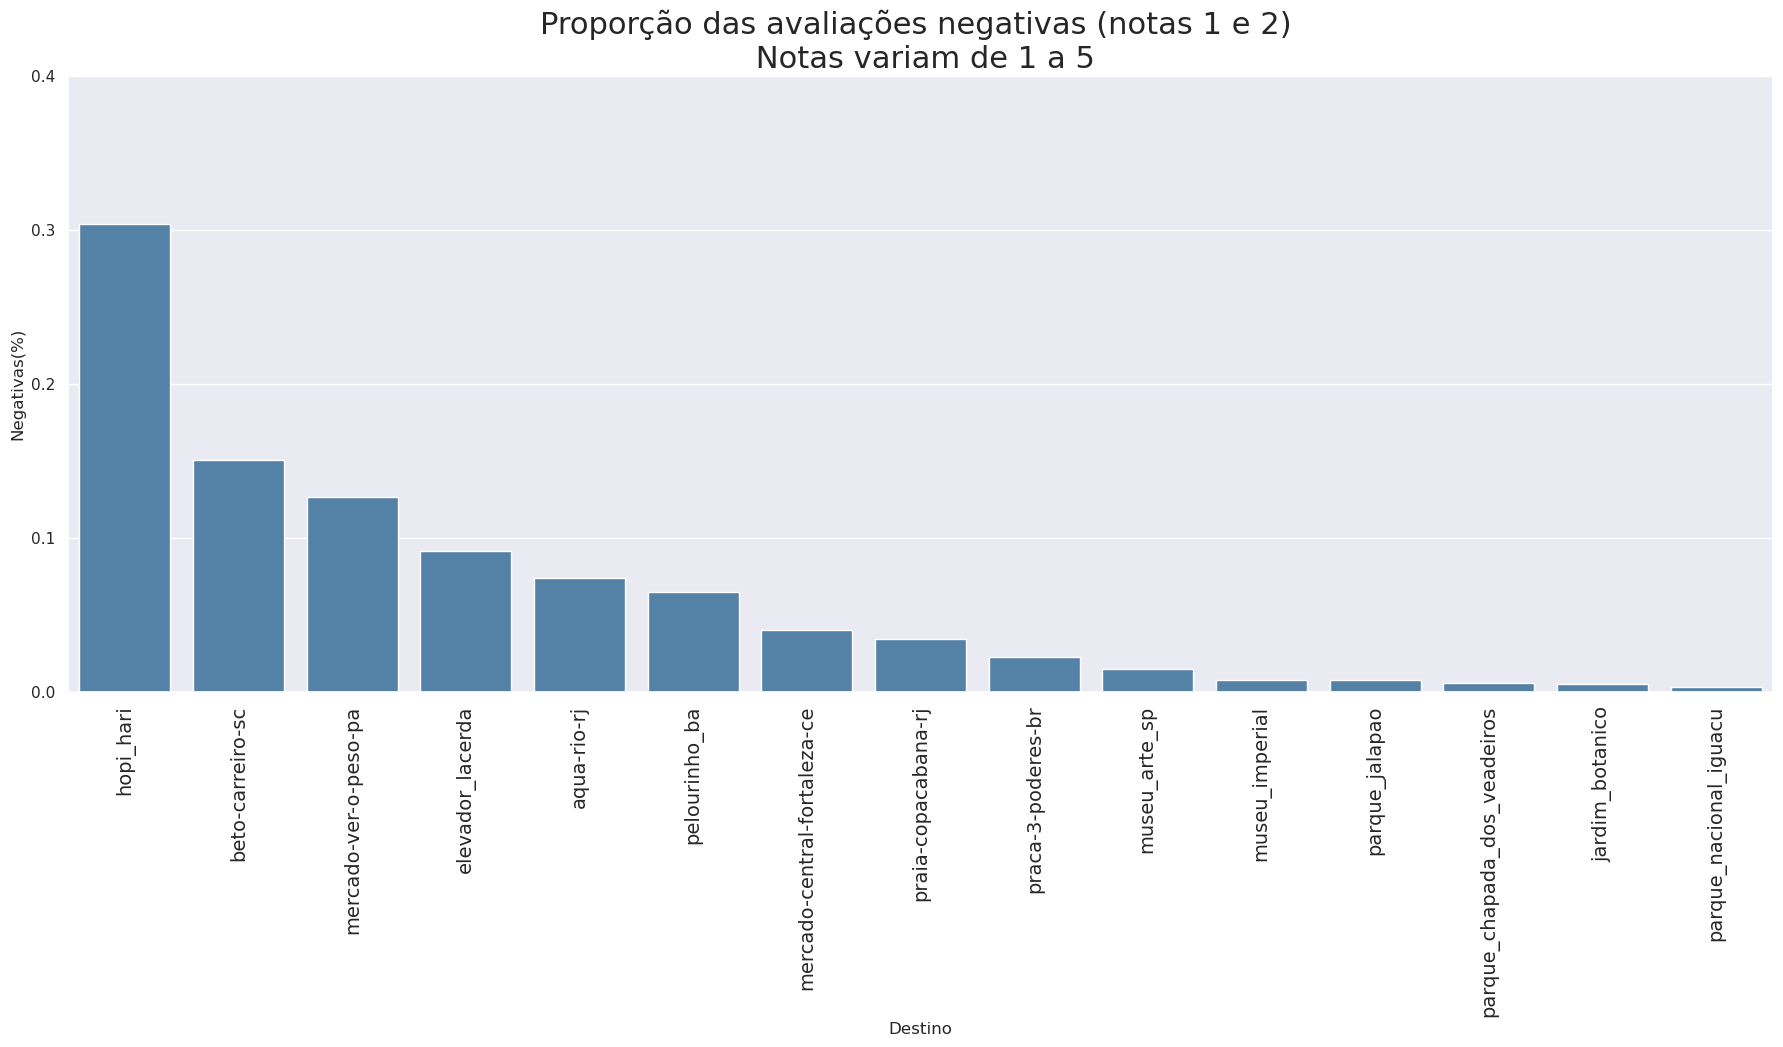

In [138]:
# Criação de gráfico para comparação entre a proporção das avaliações negativas
plt.figure(figsize=(22,8))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
plt.title('Proporção das avaliações negativas (notas 1 e 2) \n Notas variam de 1 a 5',fontsize=22)
g=sns.barplot(pos_neutra_neg.sort_values(by=['Negativas(%)'],ascending=False,inplace=True),
              x=pos_neutra_neg.index,y=pos_neutra_neg['Negativas(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.5,0.1))
plt.xlabel('Destino')

In [139]:
'''
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
row_subplot=0    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))

col_subplot=0
for atracao in nome_atracoes:
    notas_atracao=dados[atracao]
    notas_atracao=notas_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    notas_atracao.reset_index(inplace=True)
    ax=sns.barplot(notas_atracao,x='nota',y='Proporção de Avaliações',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, atracao)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao['Número_de_Avaliações'].sum()))
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])
'''

'\n#Plotar graficos com as proporções das avaliações para cada atração\nfig,axs=plt.subplots(8,2,figsize=(16,40))\nrow_subplot=0    #x=dados[nome_atracao].groupby(\'nota\').agg(Total=(\'nota\',\'count\'))\n\ncol_subplot=0\nfor atracao in nome_atracoes:\n    notas_atracao=dados[atracao]\n    notas_atracao=notas_atracao.groupby(\'nota\').agg(Número_de_Avaliações=(\'nota\',\'count\'))\n    notas_atracao[\'Proporção de Avaliações\']=notas_atracao[\'Número_de_Avaliações\']/notas_atracao[\'Número_de_Avaliações\'].sum()\n    notas_atracao.reset_index(inplace=True)\n    ax=sns.barplot(notas_atracao,x=\'nota\',y=\'Proporção de Avaliações\',ax=axs[row_subplot,col_subplot],color=\'steelblue\')\n    ax.text(-0.45, 0.95, atracao)\n    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao[\'Número_de_Avaliações\'].sum()))\n    ax.set_ylim(0,1)\n    row_subplot+=1\n    if row_subplot>7:\n        row_subplot=0\n        col_subplot=1\nfig.delaxes(axs[7][1])\n'

### Evolução anual da nota média de cada destino

In [140]:
nomes_destinos

['parque_nacional_iguacu',
 'parque_chapada_dos_veadeiros',
 'museu_imperial',
 'mercado-central-fortaleza-ce',
 'jardim_botanico',
 'aqua-rio-rj',
 'mercado-ver-o-peso-pa',
 'praia-copacabana-rj',
 'elevador_lacerda',
 'pelourinho_ba',
 'museu_arte_sp',
 'praca-3-poderes-br',
 'parque_jalapao',
 'hopi_hari',
 'beto-carreiro-sc']

In [141]:
#Criaçao de uma coluna com o ano que cada avaliação
for nome_destino in nomes_destinos:
    dados[nome_destino]['ano']=dados[nome_destino]['data'].apply(lambda x:x.split(' ')[-1])
    dados[nome_destino]=dados[nome_destino].astype({'ano':'int'})

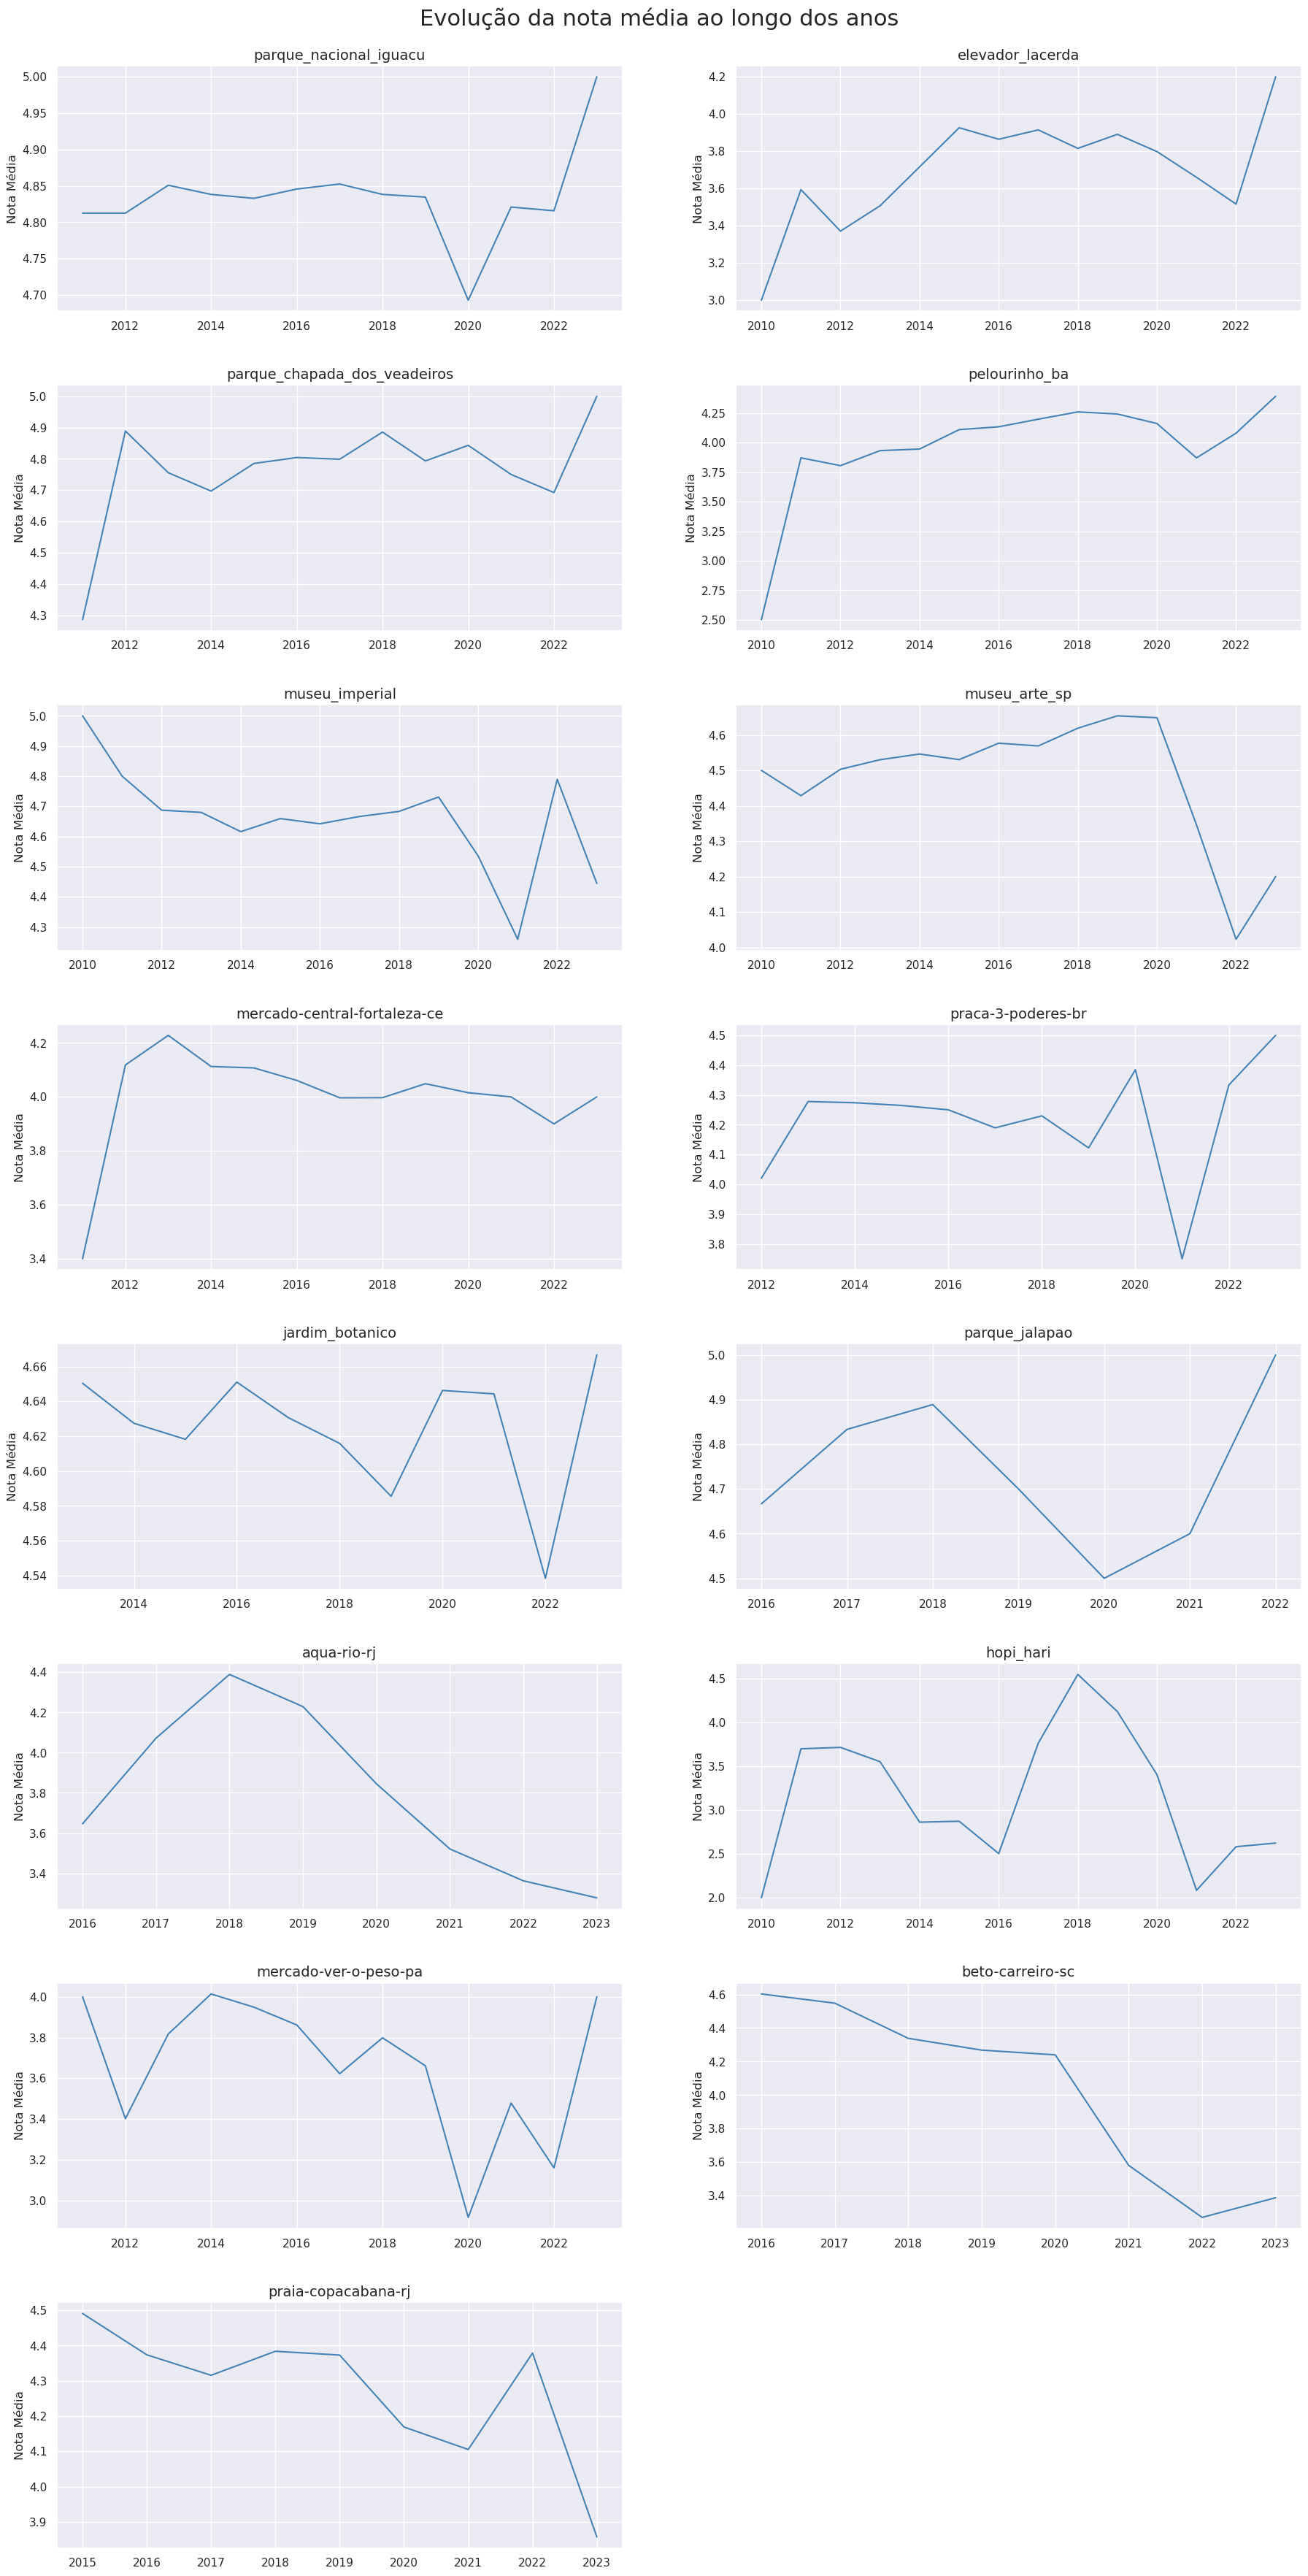

In [142]:
#Plotar graficos com as proporções das avaliações para cada destino
fig,axs=plt.subplots(8,2,figsize=(22,40))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.subplots_adjust(top=0.96) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Evolução da nota média ao longo dos anos', fontsize=22) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
row_subplot=0
col_subplot=0
for nome_destino in dados.keys():
    destino_nota_media=dados[nome_destino].groupby('ano').agg(Nota_Media=('nota','mean'))
    destino_nota_media.reset_index(inplace=True)
    ax=sns.lineplot(destino_nota_media,x='ano',y='Nota_Media',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.set(ylabel='Nota Média')
    ax.set_title(nome_destino, fontsize=14)
    ax.set(xlabel=None)
    #ax.set_ylim(0,5)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1

fig.delaxes(axs[7][1])

# Análise Exploratória - Comentários

##  Dataset

In [143]:
#Agrupar os dados de todos os destinos em um mesmo dataframe
for nome_destino in nomes_destinos:
    dados[nome_destino]['destino']=nome_destino
df_dados=pd.concat([dados[destino] for destino in nomes_destinos],axis=0)
df_dados.reset_index(inplace=True,drop=True)


In [144]:
#Inputs do modelos são os comentários e outputs são as notas
df_x=df_dados[['comentario']].copy()
df_y=df_dados[['nota']].copy()
del df_dados

In [145]:
#Dataset desbalanceado, são poucas avaliações com 1 ou 2 estrelas
df_y.value_counts()

nota
5.0     58040
4.0     26829
3.0     10902
2.0      2974
1.0      2400
Name: count, dtype: int64

In [146]:
#Aproximadamente 57% das avaliações receberam nota 5
df_y.value_counts()/len(df_y)

nota
5.0     0.573830
4.0     0.265253
3.0     0.107786
2.0     0.029403
1.0     0.023728
Name: count, dtype: float64

In [147]:
proporcao_notas_negativas=100*(df_y.value_counts()[3:].sum())/len(df_y)
print('Proporção das avaliações com notas 1 ou 2: {}%'.format(proporcao_notas_negativas))

Proporção das avaliações com notas 1 ou 2: 5.313164269118592%


In [148]:
#O conjunto de dados será dividido em treino, validação e teste
#separacao treino, validação e teste
x_treino,x_val,y_treino,y_val    =train_test_split(df_x,df_y,test_size=0.2,stratify=df_y,random_state=42)
x_treino,x_teste,y_treino,y_teste=train_test_split(x_treino,y_treino,test_size=0.2,stratify=y_treino,random_state=42)


In [149]:
#Aplicação de one hot encoding nas notas
encoder=OneHotEncoder(sparse_output=False)
y_treino_encoded=encoder.fit_transform(y_treino)
y_val_encoded   =encoder.fit_transform(y_val)
y_teste_encoded =encoder.fit_transform(y_teste)

In [150]:
#A separação dos dados de treino e teste foi feito de modo estratificado, de modo que a propoção de amostras de cada classe foi mantida após a separação
proporcao_treino_teste=pd.concat((df_y.value_counts()/len(df_y),
                        y_treino.value_counts()/len(y_treino),
                        y_val.value_counts()/len(y_val),
                        y_teste.value_counts()/len(y_teste)),axis=1)
proporcao_treino_teste.columns=['Total','Treino','Validação','Teste']
proporcao_treino_teste

,Total,Treino,Validação,Teste
nota,,,,
5.0,0.573830,0.573827,0.573830,0.573838
4.0,0.265253,0.265247,0.265263,0.265262
3.0,0.107786,0.107798,0.107766,0.107761
2.0,0.029403,0.029398,0.029413,0.029412
1.0,0.023728,0.023729,0.023728,0.023727


In [151]:
#Numero de amostras de cada nota nos dados de treino e teste
amostras_treino_teste=pd.concat((y_treino.value_counts(),y_val.value_counts(),y_teste.value_counts()),axis=1)
amostras_treino_teste.columns=['Treino','Validação','Teste']
amostras_treino_teste

,Treino,Validação,Teste
nota,,,
5.0,37145,11608,9287
4.0,17170,5366,4293
3.0,6978,2180,1744
2.0,1903,595,476
1.0,1536,480,384


In [152]:
#Apagar dataframes quenão serão mais usados
del df_x,df_y


# Undersampling

Como o dataset é desbalanceado, serão aplicadas técnicas de undersampling para reduzir o desbalanceamento.

As técnicas de undersampling que serão aplicadas são as seguintes:

- Random Undersampling
- Condensed Nearest Neighbours
- Tomek Links
- One Sided Selection
- Edited Nearest Neighbours
- Repeated Edited Nearest Neighbours
- ALL KNN

In [153]:
us_techniques={'ru' :RandomUnderSampler(random_state=42),
               'cnn':CondensedNearestNeighbour(
                        sampling_strategy='auto',  # undersamples only the majority class
                        random_state=42,  # for reproducibility
                        n_neighbors=1),
               
               'all_knn':AllKNN(
                        sampling_strategy='auto',  # undersamples only the majority class
                        n_neighbors=5, # the maximum size of the neighbourhood to examine
                        kind_sel='all'),  # all neighbours need to have the same label as the observation examined,
              
              
               'enn':EditedNearestNeighbours(
                        sampling_strategy='auto',  # resamples the majority class
                         n_neighbors=3, # the number of neighbours to examine
                        kind_sel='all'),  # all neighbours need to agree
    
               'oss':OneSidedSelection(
                        sampling_strategy='auto',  # undersamples only the majority class
                        random_state=42,  # for reproducibility
                        n_neighbors=1),# default,
              
              
               'renn':RepeatedEditedNearestNeighbours(
                        sampling_strategy='auto',# removes only the majority class
                         n_neighbors=3, # the number of neighbours to examine
                         kind_sel='all', # all neighbouring observations should show the same class
                         max_iter=100),
                           # maximum number of iterations,
               'tl':TomekLinks(
                        sampling_strategy='auto')} # undersamples only the majority class}
ru=RandomUnderSampler(random_state=42)

# Tamanho dos Comentários

O tamanho dos comentários pode ser avaliado tanto pelo número de palavras quanto pelo número de caracteres. Essa análise é importante porque alguns dos modelos que serão implementados necessitam receber inputs com o mesmo comprimento.

### Número de Palavras em cada Comentário

In [154]:
tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
x_treino['tokens']     =x_treino['comentario'].apply(lambda x:x.lower())          #letras minúsculas
x_treino['tokens']     =x_treino['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
x_treino['num_words']  =x_treino['tokens'].apply(lambda x:len(x))

In [155]:
#75% dos comentários tem menos de 45 palavras (tokens)
x_treino.describe()

,num_words
count,64732.000000
mean,39.712383
std,37.094634
min,0.000000
25%,20.000000
50%,29.000000
75%,45.000000
max,1351.000000


<Axes: title={'center': 'Número de palavras nos comentários'}, xlabel='num_words'>

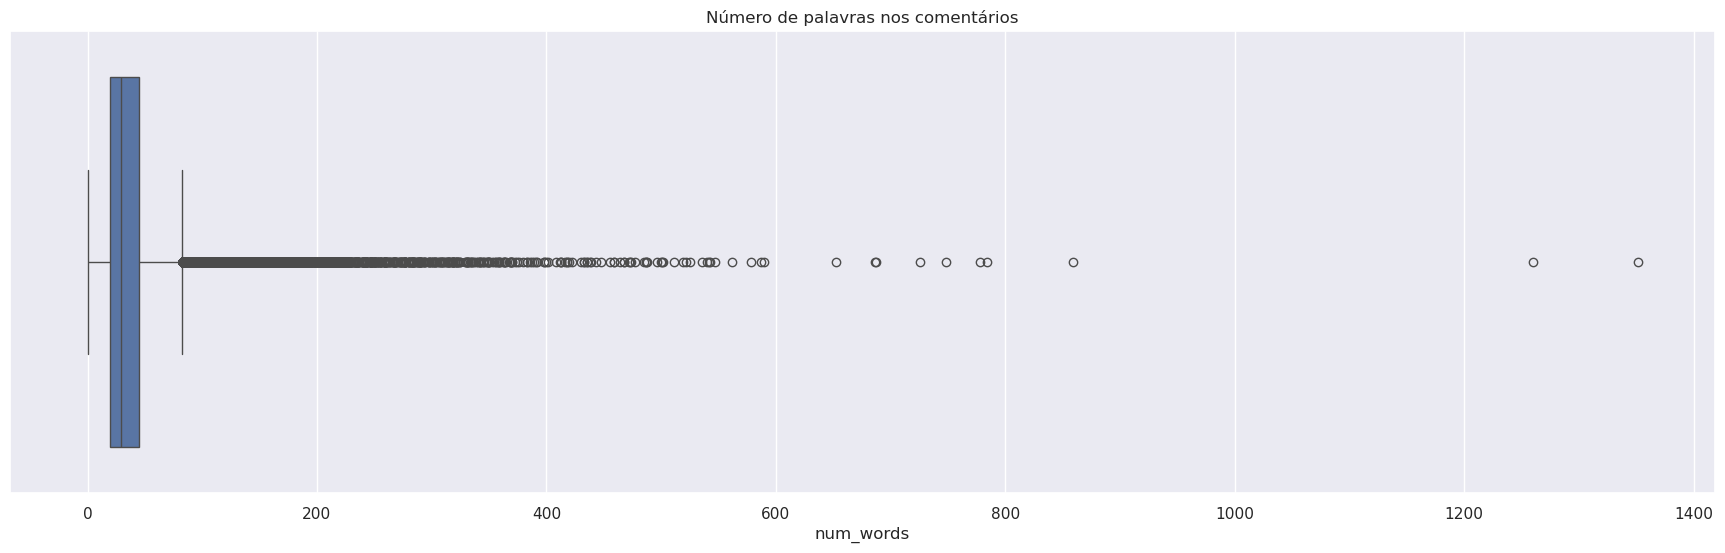

In [156]:
#Número de palavras nos comentários:
#A grande maioria dos comentários tem pequeno número de palavras, 75% deles tem menos de 45 palavras.
#Nota-se a ocorrência de comentário sem nenhum token (provavelmente os caracteres do comentário não foram reconhecidos como token no processo de tokenização)
plt.figure(figsize=[22,6])
plt.title("Número de palavras nos comentários")
sns.boxplot(data=x_treino,x='num_words',orient='h')

In [157]:
#Comentário com 0 tokens
#O comentário sem nenhum token foi escrito em outra lingua, com caracteres desconhecidos
x_treino[x_treino['num_words']==0]

,comentario,tokens,num_words
84326,"남미 최대의 미술관이라는 명성 처럼, 소장하고 있는 작품의 규모와 수준도 뛰어나지만...",[],0


Text(0.5, 12.44444444444443, 'Número de Palavras')

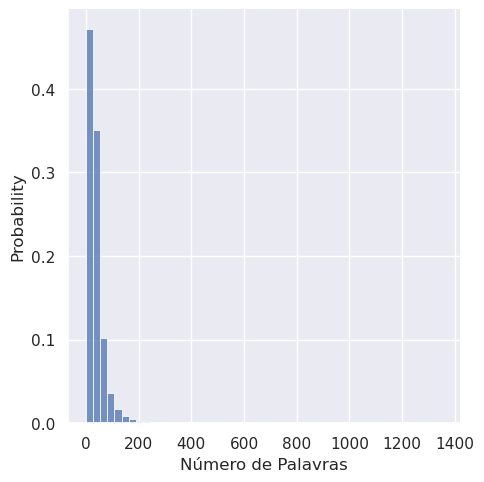

In [158]:
#A grande maioria dos comentários tem pequeno número de palavras, poucos tem mais de 200.

sns.displot(data=x_treino,x='num_words',bins=50,stat='probability' )
plt.xlabel('Número de Palavras')


### Stopwords

Stopwords são palavras que aparecem comunmente em frases e que carregam pouca informação. Esse tipo de palavra é geralmente removido em análises de processamento de linguagem natural.

In [159]:
#stopwords é uma lista com stopwords em lingua portuguesa
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords

['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as',
 'às',
 'até',
 'com',
 'como',
 'da',
 'das',
 'de',
 'dela',
 'delas',
 'dele',
 'deles',
 'depois',
 'do',
 'dos',
 'e',
 'é',
 'ela',
 'elas',
 'ele',
 'eles',
 'em',
 'entre',
 'era',
 'eram',
 'éramos',
 'essa',
 'essas',
 'esse',
 'esses',
 'esta',
 'está',
 'estamos',
 'estão',
 'estar',
 'estas',
 'estava',
 'estavam',
 'estávamos',
 'este',
 'esteja',
 'estejam',
 'estejamos',
 'estes',
 'esteve',
 'estive',
 'estivemos',
 'estiver',
 'estivera',
 'estiveram',
 'estivéramos',
 'estiverem',
 'estivermos',
 'estivesse',
 'estivessem',
 'estivéssemos',
 'estou',
 'eu',
 'foi',
 'fomos',
 'for',
 'fora',
 'foram',
 'fôramos',
 'forem',
 'formos',
 'fosse',
 'fossem',
 'fôssemos',
 'fui',
 'há',
 'haja',
 'hajam',
 'hajamos',
 'hão',
 'havemos',
 'haver',
 'hei',
 'houve',
 'houvemos',
 'houver',
 'houvera',
 'houverá',
 'houveram',
 'houvéramos',
 'houverão',
 'houverei',
 'houverem',
 'hou

In [160]:
#Calcular proporção de stopwords nos comentários
#Razão entre o número de stopwords e o número total de palavras em cada comentário
x_treino['freq_stopwords']=x_treino['tokens'].apply(lambda x:len([word for word in x if word in stopwords])/len(x) if len(x)>0 else 0)

Text(0.5, 0, 'Proporção de stopwords nos comentários')

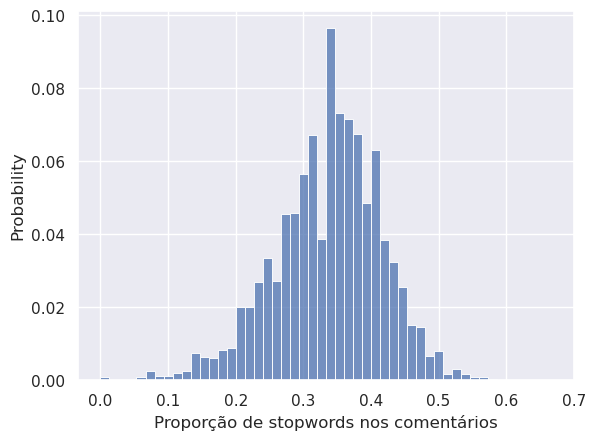

In [161]:
#A maior parte dos comentários é formada por 30 a 40% de stopwords
sns.histplot(data=x_treino,x='freq_stopwords',bins=50,stat='probability' )
plt.xlabel('Proporção de stopwords nos comentários')

In [162]:
#Remoção de stopwords
x_treino['tokens_no_stowords']=x_treino['tokens'].apply(lambda x:[word for word in x if word not in stopwords])

In [163]:
#Contagem do número de palavras em cada comentário após a remoção das stop words
x_treino['num_words_no_stopwords']  =x_treino['tokens_no_stowords'].apply(lambda x:len(x))

In [164]:
#Antes da remoção das stopwords 75% dos comentários tinham menos de 45 palavras.
#Após a remoção das stopwords 75% dos comentários tem menos de 29 palavras.
x_treino.describe()


,num_words,freq_stopwords,num_words_no_stopwords
count,64732.000000,64732.000000,64732.000000
mean,39.712383,0.335613,25.799342
std,37.094634,0.079402,23.106555
min,0.000000,0.000000,0.000000
25%,20.000000,0.285714,14.000000
50%,29.000000,0.341463,19.000000
75%,45.000000,0.388889,29.000000
max,1351.000000,0.666667,824.000000


[Text(0.5, 1.0, 'Semom Stopwords')]

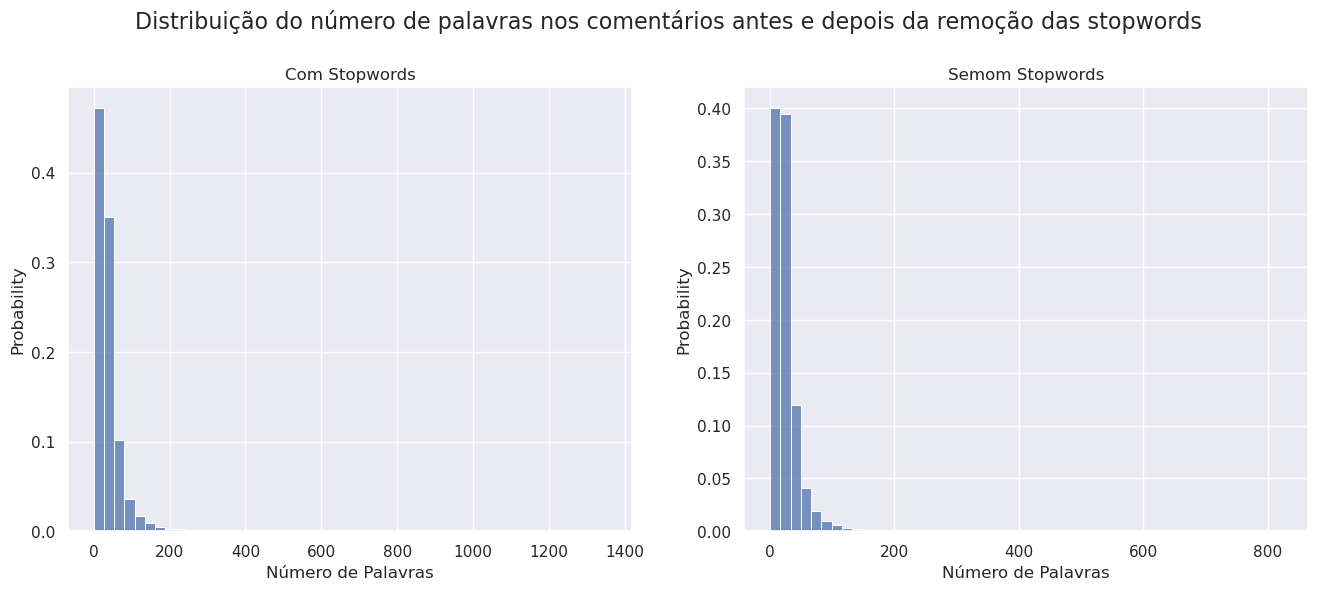

In [165]:
#Distribuição do número de palavras nos comentários antes e depois da remoção das stopwords
fig, axes = plt.subplots(1, 2,figsize=(16,6))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.subplots_adjust(top=0.85) #controla a distância entre o título geral dos subplots e os primeiros gráficos
fig.suptitle('Distribuição do número de palavras nos comentários antes e depois da remoção das stopwords', fontsize=16) #adiciona um título geral para os subplots
sns.set_theme(style='darkgrid')
sns.histplot(data=x_treino, x='num_words',bins=50,stat='probability', ax=axes[0])
sns.histplot(data=x_treino, x='num_words_no_stopwords',bins=50,stat='probability' ,ax=axes[1])
axes[0].set(xlabel='Número de Palavras')
axes[0].set(title='Com Stopwords')
axes[1].set(xlabel='Número de Palavras')
axes[1].set(title='Semom Stopwords')




In [166]:
#Remover dos dados de treino as colunas criadas

x_treino=x_treino[['comentario']].copy()

# Pré-processamento dos comentários

Para o pré processamento dos comentários serão usadas duas bibliotecas,são elas NLTK e Spacy. As etapas de pré-processamento aplicadas com essas duas bibliotecas serão praticamente os mesmos com exceção da última. A última etapa do pré-processamento com NLTK será stemming, enquando no caso da Spacy será lemmantization. Isso porque o NLTK não conta com o recurso de lemmantization em ligua portuguesa enquanto o Spacy não conta com stemming para o português.

- STEMMING: consiste em reduzir a palavra ao seu radical.
  Por exemplo as palavras amigo, amiga e amigão seriam todas reduzidas ao radical amig.

- LEMMANTIZAÇÃO: consiste em reduzir a palavra àsua forma canônica, levando em conta sua classe gramatical.
  Por exemplo  as palavras propõem, propuseram e propondo serias todas transformarmadas em propor.

## Pré-processamento com NLTK

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Remover acentos e substituir cedillha;
- Stemming.

In [167]:
def acentos_cedilha(dados, coluna='tokens'):
    '''
    Função para remover acentuação e substituir a cedilha pela letra c
    '''
    dados[coluna]=dados[coluna].apply(lambda x:[normalize('NFKD', word).encode('ASCII','ignore').decode('ASCII') for word in x])
    return dados

In [168]:
def preprocess_nltk(dados,remover_acentos=False,coluna='comentario'):
    '''
    Função recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Remoção pontuação
        -Remoção de stop words;
        -Opcional: remover acentuação e substituir cedilha (caracteres presentes na lingua portuguesa)


    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários;

    Output:
        -Dataframe com uma única coluna contendo os tokens pré-processados
    '''
    tokenizer=RegexpTokenizer(r'[A-z]\w+') #manter somente palavras nos tokens
    stopwords = nltk.corpus.stopwords.words('portuguese') #lista de stopwords na lingua portuguesa
    dados=dados.copy()
    dados['tokens']     =dados[coluna].apply(lambda x:x.lower())          #letras minúsculas
    dados['tokens']     =dados['tokens'].apply(lambda x:tokenizer.tokenize(x))  #tokenizer e remover pontuação
    dados['tokens']     =dados['tokens'].apply(lambda x:[word for word in x if word not in stopwords]) #remover stop words
    if remover_acentos:
        dados=acentos_cedilha(dados)
    dados.drop(coluna,axis=1,inplace=True)
    return dados

In [169]:
#Função que aplica stemming
def stemmming_nltk(dados,coluna='tokens'):
    '''
    Função que aplica stemming na coluna especificada

    Inputs:
        -Dataframe com coluna contendo lista com tokens

    Outputs:
        -Dataframe original com stemming aplicado nos tokens
    '''
    stemmer=nltk.RSLPStemmer()
    dados[coluna]=dados[coluna].apply(lambda x:[stemmer.stem(word) for word in x]) #stemming nos tokens
    return dados

## Pré-processamento com Spacy

- Converter todas as palavras para minúsculas;
- Tokenizar o comentário;
- Manter nos tokens somente as palavras;
- Remover stopwords;
- Lemmantization.

In [170]:
def lemmantizar(dados,remover_acentos=False,coluna='comentario'):
    '''
    Função recebe como input um dataframe com uma coluna contendo os comentários. Serão aplicadas as seguintes etapas de pré-processamento nos comentários:
        -Letras todas minúsculas;
        -Tokenização;
        -Somente palavras nos comentários (remoção de pontuação, números, etc)
        -Remoção de stop words;
        -lemmantization;

    Inputs:
        -Dataframe com comentários;
        -Remover acentos - True or false. Default false
        -Nome da coluna onde estão os comentários;

    Output:
        -Dataframe com uma única coluna contendo em cada linha uma lista de tokens pré-processados
    '''
    dados=dados.copy()
    nlp=spacy.load("pt_core_news_lg")
    dados['tokens']=dados[coluna].apply(lambda x:x.lower()) #letras minúsuculas
    dados['tokens']=dados['tokens'].apply(lambda x: [token.lemma_ for token in nlp(x) if token.is_alpha and not token.is_stop]) #manutenção somente de palavras nos tokens
    if remover_acentos:
        dados=acentos_cedilha(dados)                                                                                                                            #e remoção de stopwords
    dados.drop(coluna,axis=1,inplace=True) #mantém somente a coluna com os tokens criados
    return dados

### Pipelines de pré-processamento


Serão criadas pipeline de pré-processamento dos comentários que contarão com as seguites etapas:

- Pré-processamento com biblioteca NLTK ou Spacy;
- Opcional: remoção de acentuação e substituição de cedilha;
- Padroninação do número de palavras nos comentários.


Datasets:

- x_treino, y_treino_encoded
- x_val   , y_val_encoded
- x_teste , y_teste_encoded


In [171]:
def padronizar_num_tokens(dados,num_words=25,coluna='tokens'):
    '''
    Função para padranizar o número de palavras nos comentários.
    Comentários com número de palavras maior que o especificado serão truncados, enquanto aos com número maior será aplicado padding

    inputs-
    dados     - dataframe com coluna contendo os tokens dos comentátios
    coluna    - coluna com tokens
    max_words - número máximo de palavras em cada comentário

    outputs-
    Dataframe com todos os comentários com mesmo número de tokens;
    Cada comentário no formato [1,num_words]
    '''
    dados[coluna]=dados[coluna].apply(lambda x: [x[:num_words]if len(x)>num_words else x+(num_words-len(x))*['pad']])
    dados[coluna]=dados[coluna].apply(lambda x:np.array(x).reshape([1,-1]))
    dados=np.array(dados[coluna])
    dados=np.concatenate(dados,axis=0)
    return dados

In [172]:
# Pipeline com NLTK

pipeline_NLTK=make_pipeline(
            FunctionTransformer(preprocess_nltk),
            FunctionTransformer(stemmming_nltk),
            FunctionTransformer(padronizar_num_tokens))

In [173]:
# Pipeline com Spacy

pipeline_Spacy=make_pipeline(
            FunctionTransformer(lemmantizar),
            FunctionTransformer(padronizar_num_tokens))

In [174]:
def criar_datasets(treino,validacao,teste,pipeline='nltk'):
    '''
    Função para criar 4 datasets. Aos datasets poderá ser aplicado pré-processamento com lemmantização ou stemming.

    Inputs:
    treino                   - dataset com todo o conjunto de dados de treino
    validacao                - dataset com os dados para validacao
    teste                    - dataset com os dados para teste
    pipeline ()              - tipo de pré-porcessamento que será aplicado. Se nltk será aplicado stemming, caso spacy lemmantizacao. Default nltk.

    '''
    
    if pipeline !='nltk' and pipeline!='spacy':
        raise Exception('Pipeline desconhecida. Valores aceitos para pipeline são "nltk" ou "spacy"')

    if pipeline=='nltk':
        treino             =pipeline_NLTK.fit_transform(treino)
        validacao          =pipeline_NLTK.fit_transform(validacao)
        teste              =pipeline_NLTK.fit_transform(teste)
    else:
        treino             =pipeline_Spacy.fit_transform(treino)
        validacao          =pipeline_Spacy.fit_transform(validacao)
        teste              =pipeline_Spacy.fit_transform(teste)

    return treino,validacao,teste



In [175]:
#Criação de datasets 

#x_treino_stem,x_val_stem,x_teste_stem=criar_datasets(x_treino,x_val,x_teste,pipeline='nltk') #Stemming
#x_treino_lemman,x_val_lemman,x_teste_lemman=criar_datasets(x_treino,x_val,x_teste,pipeline='spacy') #lemmantização


#np.save('../stem/'+'x_treino_stem.npy',x_treino_stem)
#np.save('../stem/'+'x_val_stem.npy',x_val_stem)
#np.save('../stem/'+'x_teste_stem.npy',x_teste_stem)

#np.save('../lemman/x_treino_lemman.npy',x_treino_lemman)
#np.save('../lemman/x_val_lemman.npy',x_val_lemman)
#np.save('../lemman/x_teste_lemman.npy',x_teste_lemman)



In [176]:
#Os datasets já estão salvos

if stem_or_lemman=='stem':

    x_treino_stem              =np.load('../stem/x_treino_stem.npy')
    x_val_stem                 =np.load('../stem/x_val_stem.npy')
    x_teste_stem               =np.load('../stem/x_teste_stem.npy')

else:
    x_treino_lemman              =np.load('../lemman/x_treino_lemman.npy')
    x_val_lemman                 =np.load('../lemman/x_val_lemman.npy')
    x_teste_lemman               =np.load('../lemman/x_teste_lemman.npy')

## Análise da frequência que cada palavra aparece nos comentários com cada nota

In [177]:
#Contar o número de vezes que cada palavra aparece nos comentários com a mesma nota e também o número total de vezes que cada palavra aparece
nota1_count=Counter()
nota2_count=Counter()
nota3_count=Counter()
nota4_count=Counter()
nota5_count=Counter()
total=Counter()

In [178]:
if stem_or_lemman=='lemman':
    x_dataset,y_dataset=ru.fit_resample(x_treino_lemman,y_treino)
    y_dataset=np.array(y_dataset)
else:
    x_dataset,y_dataset=ru.fit_resample(x_treino_stem,y_treino)
    y_dataset=np.array(y_dataset)


In [179]:
#varrer todos os comentário fazendo a contagem do número de vezes que as palavras aparecem
for num_row in range(len(x_dataset)):
    if y_dataset[num_row]==1:
        nota1_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==2:
        nota2_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==3:
        nota3_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==4:
        nota4_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

    elif y_dataset[num_row]==5:
        nota5_count.update(x_dataset[num_row])
        total.update(x_dataset[num_row])

In [180]:
#Palavras mais comuns nos comentários com nota 1
nota1_count.most_common()

[('pad', 6785),
 ('parque', 915),
 ('fila', 850),
 ('brinquedo', 718),
 ('dia', 364),
 ('hora', 354),
 ('atração', 274),
 ('pessoa', 260),
 ('pra', 250),
 ('ficar', 247),
 ('ingresso', 213),
 ('conseguir', 195),
 ('ter', 190),
 ('entrar', 176),
 ('comprar', 171),
 ('ser', 169),
 ('haver', 169),
 ('chegar', 162),
 ('péssimo', 161),
 ('sujo', 158),
 ('fechar', 155),
 ('estar', 152),
 ('funcionar', 147),
 ('experiência', 140),
 ('pagar', 139),
 ('muito', 136),
 ('elevador', 135),
 ('caro', 135),
 ('ano', 132),
 ('criança', 129),
 ('estacionamento', 122),
 ('passar', 120),
 ('recomendar', 113),
 ('valer', 111),
 ('absurdo', 111),
 ('funcionário', 107),
 ('andar', 106),
 ('entrada', 106),
 ('manutenção', 105),
 ('horrível', 104),
 ('lotar', 101),
 ('pena', 100),
 ('preço', 100),
 ('mau', 97),
 ('hopi', 97),
 ('ir', 96),
 ('visitar', 96),
 ('montanha', 96),
 ('vc', 93),
 ('voltar', 92),
 ('bom', 91),
 ('enorme', 87),
 ('russo', 86),
 ('cheio', 85),
 ('ver', 85),
 ('hari', 84),
 ('gente', 84)

In [181]:
#Palavras mais comuns nos comentários com nota 5

nota5_count.most_common()

[('pad', 14447),
 ('parque', 405),
 ('passeio', 261),
 ('valer', 255),
 ('lindo', 245),
 ('visitar', 231),
 ('pena', 212),
 ('conhecer', 189),
 ('bom', 183),
 ('jardim', 181),
 ('cuidado', 175),
 ('dia', 173),
 ('museu', 172),
 ('maravilhoso', 163),
 ('cidade', 161),
 ('muito', 149),
 ('bonito', 145),
 ('pra', 143),
 ('visita', 139),
 ('ficar', 135),
 ('foto', 122),
 ('trilha', 122),
 ('excelente', 122),
 ('família', 121),
 ('praia', 118),
 ('história', 116),
 ('natureza', 116),
 ('limpo', 113),
 ('atração', 111),
 ('lir', 107),
 ('gostar', 102),
 ('deixar', 102),
 ('passar', 99),
 ('recomendar', 98),
 ('organizar', 92),
 ('catarata', 88),
 ('Brasil', 88),
 ('pessoa', 86),
 ('criança', 81),
 ('botânico', 79),
 ('super', 79),
 ('ótimo', 79),
 ('andar', 79),
 ('preço', 78),
 ('pelourinho', 78),
 ('levar', 78),
 ('estrutura', 77),
 ('imperdível', 76),
 ('incrível', 76),
 ('beleza', 75),
 ('haver', 74),
 ('tirar', 73),
 ('restaurante', 73),
 ('Curitiba', 72),
 ('show', 72),
 ('obra', 72),


In [182]:
#Palavras mais comuns nos comentários com nota 2
nota2_count.most_common()

[('pad', 9327),
 ('parque', 533),
 ('fila', 448),
 ('brinquedo', 411),
 ('atração', 270),
 ('elevador', 243),
 ('pessoa', 227),
 ('dia', 225),
 ('ficar', 225),
 ('muito', 203),
 ('ser', 183),
 ('haver', 181),
 ('valer', 175),
 ('sujo', 174),
 ('pra', 171),
 ('mercado', 161),
 ('cidade', 154),
 ('hora', 151),
 ('bom', 151),
 ('pena', 151),
 ('ter', 139),
 ('preço', 138),
 ('cuidado', 137),
 ('estar', 135),
 ('visitar', 135),
 ('fechar', 133),
 ('achar', 133),
 ('bonito', 129),
 ('caro', 122),
 ('conhecer', 122),
 ('turista', 121),
 ('ano', 118),
 ('vista', 112),
 ('funcionar', 111),
 ('chegar', 109),
 ('ver', 108),
 ('conseguir', 107),
 ('praia', 106),
 ('esperar', 105),
 ('ingresso', 105),
 ('estacionamento', 104),
 ('comprar', 103),
 ('pelourinho', 101),
 ('deixar', 101),
 ('entrar', 100),
 ('pouco', 99),
 ('criança', 98),
 ('pagar', 98),
 ('alto', 96),
 ('visita', 93),
 ('gostar', 92),
 ('manutenção', 91),
 ('andar', 90),
 ('rua', 88),
 ('turístico', 87),
 ('salvador', 86),
 ('entrad

In [183]:
#Palavras menos comuns nos comentários com nota 5
nota5_count.most_common()[-1:-20:-1]

[('nacuional', 1),
 ('itaú', 1),
 ('Inglaterra', 1),
 ('galpão', 1),
 ('hortifruti', 1),
 ('muda', 1),
 ('procuro', 1),
 ('viajo', 1),
 ('aguentar', 1),
 ('catara', 1),
 ('cade', 1),
 ('manha', 1),
 ('instalacoes', 1),
 ('castelo', 1),
 ('jardinagem', 1),
 ('familiarbom', 1),
 ('opçãocom', 1),
 ('dasárvor', 1),
 ('relatosinteressante', 1)]

In [184]:
#Palavras menos comuns nos comentários com nota 1
nota1_count.most_common()[-1:-20:-1]

[('despistar', 1),
 ('poderpublico', 1),
 ('irregularidade', 1),
 ('Bilhetes', 1),
 ('Cristo', 1),
 ('salva', 1),
 ('pagos', 1),
 ('gorduroso', 1),
 ('porção', 1),
 ('marcação', 1),
 ('mijo', 1),
 ('congestionar', 1),
 ('legalzinho', 1),
 ('politico', 1),
 ('criação', 1),
 ('raia', 1),
 ('abixo', 1),
 ('status', 1),
 ('pontuar', 1)]

Entre as palavras mais comuns nos comemtários com nota 5 aparecem algumas com conotação extremamente positiva, como maravilhoso e excelente. Enquanto nos comentários com nota 1 já aparecem palavras com conotação negativa, como péssimo e sujo por exemplo. Porém a maior parte das palavras não tem nenhum tipo de conotação, como por exemplo as palavras parque, brinquedo, dia nos comentários com nota 1.Já verificando as palavras que aparecem com menor frequência, verifica-se a ocorrência de palavras incomuns, com grafia errada e com erros de digitação. Palavras que aparecem raramente não podem ser empregadas para caracterizar um conjunto de comentários.



Para facilitar a comparação das palavras que aparecem com maior frequência em cada nota, será calculada a razão entre o número de vezes que cada palavra aparece em comentários com certa nota e o número de vezes em que a palavra apareceu em todos os comentários.Para esse calculo é necessário usar os dados com amostragem, para que o número de comentários com cada nota seja igual. Por exemplo, caso a palavra excelente apareça somente em comentários com nota 5, a razão para essa palavra será 1 para nota 5 e 0 para os demais. Ou seja, palavras que apareçam com maior frequência em comentários com certa nota terão razao mais próximas de 1.





In [185]:
#Palavras raras serão desconsideradas no cálculo das razões
def calcular_razao(counter_nota,counter_total,min_freq):
    '''
    Função para calcular a razão entre o numero de vezes que a palavra aparece em comentários com certa nota e o nḿero de vezes que a palavra aparece em
    todos os comentários

    inputs:
    counter_nota  - objeto Counter com número de vezes que as palavras aparerem em comentários com certa nota
    counter_total - objeto Counter com número de vezes que as palavras aparerem no conjunto de todos os comentrários
    min_freq      - número mínimo de vezes que uma palavra deve aparecer para ser consideradas. Palavras raras não são úteis para caracterizar os comentários
    '''
    razao=Counter()
    for palavra in counter_nota:
        if counter_nota[palavra]>min_freq:
            razao[palavra]=counter_nota[palavra]/counter_total[palavra]
    return razao


min_freq=20 #Palavra deve ter aparecido no mínimo cem vezes para ser considerada

razao_nota5=calcular_razao(nota5_count,total,min_freq)
razao_nota4=calcular_razao(nota4_count,total,min_freq)
razao_nota3=calcular_razao(nota3_count,total,min_freq)
razao_nota2=calcular_razao(nota2_count,total,min_freq)
razao_nota1=calcular_razao(nota1_count,total,min_freq)

print('Número de palavras para comentários com nota 5: {}'.format(len(razao_nota5)))
print('Número de palavras para comentários com nota 4: {}'.format(len(razao_nota4)))
print('Número de palavras para comentários com nota 3: {}'.format(len(razao_nota3)))
print('Número de palavras para comentários com nota 2: {}'.format(len(razao_nota2)))
print('Número de palavras para comentários com nota 1: {}'.format(len(razao_nota1)))

Número de palavras para comentários com nota 5: 224
Número de palavras para comentários com nota 4: 258
Número de palavras para comentários com nota 3: 264
Número de palavras para comentários com nota 2: 280
Número de palavras para comentários com nota 1: 277


In [186]:
razao_nota5.most_common()

[('iguaçu', 0.7755102040816326),
 ('queda', 0.7),
 ('catarata', 0.6717557251908397),
 ('argentino', 0.6590909090909091),
 ('perfeito', 0.6582278481012658),
 ('amei', 0.6578947368421053),
 ('natureza', 0.6338797814207651),
 ('cachoeira', 0.6041666666666666),
 ('trilha', 0.5922330097087378),
 ('imperdível', 0.5846153846153846),
 ('encantar', 0.578125),
 ('petrópoli', 0.575),
 ('ônibus', 0.574468085106383),
 ('maravilhoso', 0.5451505016722408),
 ('contato', 0.5370370370370371),
 ('excelente', 0.5),
 ('sinalizar', 0.4909090909090909),
 ('acervo', 0.48936170212765956),
 ('imperial', 0.4883720930232558),
 ('espetáculo', 0.4807692307692308),
 ('fantástico', 0.47761194029850745),
 ('incrível', 0.475),
 ('paisagem', 0.47115384615384615),
 ('Curitiba', 0.47058823529411764),
 ('curitiba', 0.4676258992805755),
 ('nacional', 0.4606741573033708),
 ('beleza', 0.4601226993865031),
 ('belíssimo', 0.4583333333333333),
 ('caminhada', 0.45806451612903226),
 ('banho', 0.45098039215686275),
 ('flor', 0.4503

In [187]:
razao_nota3.most_common()

[('entanto', 0.56),
 ('erva', 0.44),
 ('baixo', 0.41203703703703703),
 ('ligar', 0.40540540540540543),
 ('centavo', 0.4024390243902439),
 ('si', 0.3916083916083916),
 ('transporte', 0.3898305084745763),
 ('construção', 0.38666666666666666),
 ('regional', 0.38461538461538464),
 ('assalto', 0.38271604938271603),
 ('comum', 0.38271604938271603),
 ('modelo', 0.3787878787878788),
 ('produto', 0.37272727272727274),
 ('castanha', 0.37037037037037035),
 ('panorâmico', 0.3684210526315789),
 ('vidro', 0.36619718309859156),
 ('bolsa', 0.36507936507936506),
 ('Brasília', 0.36486486486486486),
 ('interessante', 0.3643835616438356),
 ('tradicional', 0.35714285714285715),
 ('santo', 0.35384615384615387),
 ('desejar', 0.35294117647058826),
 ('policiamento', 0.35294117647058826),
 ('fruta', 0.34615384615384615),
 ('achar', 0.3446601941747573),
 ('necessário', 0.34375),
 ('legal', 0.343042071197411),
 ('local', 0.3423913043478261),
 ('artesanato', 0.3389830508474576),
 ('atenção', 0.33884297520661155),


In [188]:
razao_nota2.most_common()

[('higiene', 0.5217391304347826),
 ('impressão', 0.4909090909090909),
 ('cheirar', 0.4772727272727273),
 ('desorganizar', 0.47368421052631576),
 ('sujeira', 0.4489795918367347),
 ('abandonado', 0.4444444444444444),
 ('urina', 0.4305555555555556),
 ('caríssimo', 0.42857142857142855),
 ('triste', 0.42857142857142855),
 ('decepção', 0.4144144144144144),
 ('decepcionar', 0.4117647058823529),
 ('reforma', 0.410958904109589),
 ('pedinte', 0.4028776978417266),
 ('expectativa', 0.3939393939393939),
 ('sujo', 0.3918918918918919),
 ('feio', 0.3888888888888889),
 ('último', 0.37349397590361444),
 ('mesmo', 0.37168141592920356),
 ('pedir', 0.37142857142857144),
 ('gigante', 0.3698630136986301),
 ('pouco', 0.3626373626373626),
 ('fechar', 0.36239782016348776),
 ('insegurança', 0.36065573770491804),
 ('aquário', 0.3601694915254237),
 ('horário', 0.3592233009708738),
 ('fechado', 0.35714285714285715),
 ('abordar', 0.35658914728682173),
 ('tratar', 0.35294117647058826),
 ('funcionar', 0.35238095238095

In [189]:
razao_nota1.most_common()

[('horrível', 0.8),
 ('desrespeito', 0.7714285714285715),
 ('lamentável', 0.7586206896551724),
 ('pandemia', 0.717391304347826),
 ('respeito', 0.704225352112676),
 ('capacidade', 0.6896551724137931),
 ('total', 0.6888888888888889),
 ('vip', 0.660377358490566),
 ('descaso', 0.6363636363636364),
 ('mau', 0.6258064516129033),
 ('péssimo', 0.6192307692307693),
 ('interminável', 0.6181818181818182),
 ('limite', 0.6111111111111112),
 ('espera', 0.6090225563909775),
 ('cliente', 0.6086956521739131),
 ('site', 0.6063829787234043),
 ('gigantesco', 0.6037735849056604),
 ('furar', 0.5869565217391305),
 ('metade', 0.5777777777777777),
 ('promoção', 0.575),
 ('absurdo', 0.5721649484536082),
 ('totalmente', 0.5692307692307692),
 ('gastar', 0.5692307692307692),
 ('ninguém', 0.5657894736842105),
 ('pass', 0.5641025641025641),
 ('condição', 0.56),
 ('atendente', 0.55),
 ('hora', 0.5404580152671755),
 ('avisar', 0.5365853658536586),
 ('passaporte', 0.5344827586206896),
 ('quebrar', 0.5285714285714286),


Analisando as palavras com maior razão nos comentários com nota 5,ou seja, aquelas palavras que aparecem proporcionalmente com maior frequência nos comentários com nota 5, estão palavras com conotação positiva como lindo maravilhoso e excelente.Por exemplo, em 53% dos comentários onde a palavra maravilhoso apareceu a nota do comentário era 5.Já para os comentários com nota 1, encontramos palavras de conotação negativa como horrível, péssimo, filas, etc.Por exemplo, em 75% dos comentários que em que a palavra horrível apareceu a nota do comentário era 1.Lembrando que as palavras incomuns foram excluídas do cáculo da razão.

In [190]:
#Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
def numero_ocorrencias(palavra):
    '''
    Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
    A contagem será feita no conjunto de dados com mesmo número amostras de cada comentário para possibilitar a comparação

    Input
    palavra (palavra) - A palavra para a qual se deseja exibir a contagem
    '''
    print('Número de vezes que a palavra {} apareceu nos comentários: '.format(palavra))
    print('')
    print('Nota 5: {}'.format(nota5_count[palavra]))
    print('Nota 4: {}'.format(nota5_count[palavra]))
    print('Nota 3: {}'.format(nota3_count[palavra]))
    print('Nota 2: {}'.format(nota2_count[palavra]))
    print('Nota 1: {}'.format(nota1_count[palavra]))


In [191]:
#Exibindo o número de ocorrências da palavra maravilhoso nos comentários com cada nota
#Interessante notar que a palavra maravilhoso aparece am alguns comentários com notas ruins
numero_ocorrencias('maravilhoso')

Número de vezes que a palavra maravilhoso apareceu nos comentários: 

Nota 5: 163
Nota 4: 163
Nota 3: 30
Nota 2: 17
Nota 1: 13


In [192]:
#Exibindo o número de ocorrências da palavra péssimo nos comentários com cada nota
numero_ocorrencias('pessimo')

Número de vezes que a palavra pessimo apareceu nos comentários: 

Nota 5: 0
Nota 4: 0
Nota 3: 1
Nota 2: 5
Nota 1: 18


In [193]:
#Vamos verificar exemplos de comentarios com as notas e palavras selecionadas
nota_selecionada=1
palavra_selecionada='maravilhoso'
exemplos=[]
for row_comentario in range(len(y_treino)): #uso do dataset sem undersampling, pra permitir a visualização do comentário antes da aplicação do pré-processamento
    #x_treino e y_treino são dataframes sem undersampling e sem pré-processamento
    #x_treino lemman foi usado para facilitar a busca das palavras, porque nele foi aplicada tokenização nos comentários
    if ((y_treino.iloc[row_comentario,0]==nota_selecionada) and (palavra_selecionada in x_treino_lemman[row_comentario])):
        exemplos+=[x_treino.iloc[row_comentario,0]]


In [194]:
exemplos[1]

'O Aqua Rio  é maravilhoso e até quero voltar! Mas, as atendentes pior do que os bichos. Tudo de mal humor, estressadas e não educadas, tem uma loirinha nossa, ranço da cara dela ô mulherzinha grossa! Só pelo mal atendimento minha nota nesse momento é 1. '

# Rede Neural Multi Layer Perceptron


Nessa seção será criada uma rede neural que classificará cada comentário de acordo com as palavras que ele contem.Conforme verificado no tópico anterior, certas palavras aparecem com maior frequência em comentários com determinada nota. Para selecionar as palavras que serão usadas para caracterizar os comentários será usada a razão entre o número de vezes que a palavra apareceu em comentários com certa notas e o número total de vezes que a palavra apareceu em todos os comentários. Será escolhido um threshold, onde somente as palavras com razão acima desse valor serão usadas pela rede. Lembrando que uma palavra que aparece em todo tipo de comentário tem razão aproximandamente igual a 0.2. As palavras cuja razão superarem esse threshold serão incluídas em um dicionário em que as palavras serão as chaves e os valores serão números que servirão para identificar cada palavra.

Serão testadas 3 redes:

- Rede para classificar a nota de cada comentário;
- Rede para classificar cada comentário como positivo, negativo e neutro;
- Rede para classificar cada comentário como positivo e negativo.

## Preparação dos dados para a rede MLP

In [195]:
#Selecionar dados que serão usados

if stem_or_lemman=='lemman':
    x_MLP_treino              =x_treino_lemman
    x_MLP_val                 =x_val_lemman
    x_MLP_teste               =x_teste_lemman

else:
    x_MLP_treino              =x_treino_stem
    x_MLP_val                 =x_val_stem
    x_MLP_teste               =x_teste_stem

In [196]:
#Criação de um vocabuário
'''
O vocabulário conterá todas as palavras que serão usadas para classificar a nota de um comentário. É um dicionário em que as chaves são as
palavras selecionadas e os valores são números que servirão como identificador para cada palavra. As palavras selecionadas para fazer parte
do vocabulário são aquelas em que a razão entre o número de aparições em comentários com certa nota e o número total de aparições supera
certo threshold especificado.
'''

threshold=0.2
vocab_MLP={}
razoes=[razao_nota1,
        razao_nota2,
        razao_nota3,
        razao_nota4,
        razao_nota5]
num=0
for razao_nota in razoes:
    for palavra,razao in razao_nota.most_common():
        if razao>=threshold and palavra not in vocab_MLP.keys():
            vocab_MLP[palavra]=num
            num+=1

print(len(vocab_MLP))

450


As entradas da rede neural serão os comentários. Porém as palavras desses cometários deverão ser transformadas em valores numéricos para que possam ser usados pela rede neural. Cada comentário será convertido em um vetor [1,n_palavras] onde n_palavras é o número total de palavras presente no vocabulário criado. Esse vetor terá 0s para indicar que a palavra não está presente no comentário e 1s caso contrário. As posições no vetor que receberão os valores 1 serão os valores das palavras no vocabulário criado. Por exemplo, imagine que a palavra horrivel receba o valor 10 no vocabulário. Caso a palavra horrivel esteja no comentário, o index 10 do vetor receberá o valor 1.

In [197]:
def converter_comentarios(comentarios, vocab):
    '''
    Função que transforma os comentários em entradas numéricas para a rede neural

    inputs :

    comentarios - dataframe com os comentários
    vocab       - dicionário com o vacabulário criado, nop qual as palavras são as chaves e os valores um indicador para cada palavra
    '''

    x_numerico=np.zeros([len(comentarios),len(vocab)])
    for row_comentario in range(len(comentarios)):
        for word in comentarios[row_comentario]:
            if word in vocab.keys():
                x_numerico[row_comentario,vocab[word]]=1
    return x_numerico

In [198]:
#Converter comentários para entradas numéricas
x_MLP_treino_numerico              =converter_comentarios(x_MLP_treino,vocab_MLP)
x_MLP_val_numerico                 =converter_comentarios(x_MLP_val,vocab_MLP)
x_MLP_teste_numerico               =converter_comentarios(x_MLP_teste,vocab_MLP)


### Metrics baseline


O valor baseline para uma métrica é um valor base contra o qual o desempenho do modelo será comparado.O dataset é desbalanceado aproximadamente 57% de todas as avaliações atribuíram nota 5. Sendo assim um modelo que predissesse somente notas 5 teria uma acurácia de 57%. Portando o valor da baseline para a acurácia será 57%.

In [199]:
proporcao_treino_teste

,Total,Treino,Validação,Teste
nota,,,,
5.0,0.573830,0.573827,0.573830,0.573838
4.0,0.265253,0.265247,0.265263,0.265262
3.0,0.107786,0.107798,0.107766,0.107761
2.0,0.029403,0.029398,0.029413,0.029412
1.0,0.023728,0.023729,0.023728,0.023727


### Criação de dasets desbalanceados


In [200]:
#Técnicas de undersampling que serão aplicadas

path='../'+stem_or_lemman+'/undersampled/'

def undersample_datasets(dict_tecniques,path,x,y,x_file_name='x_MLP_undersampled_',y_file_name='y_MLP_undersampled_'):
    #Função para aplicar undersampling no dataset e salvar em diretório especificado
    '''
    inputs:
        dict_tecniques - dicionário com técnicas de undersampling que serão aplicadas
        path           - caminho para salvar os datasets criados
        x              - input data sem undersampling
        y              - output data sem undersampling
        x_file_name    - nome do arquivo que será salvo. A esse nome será acrescentado o nome da técnica aplicada
        y_file_name    - nome do arquivo que será salvo. A esse nome será acrescentado o nome da técnica aplicada
    '''
    for technique in us_techniques.keys():
        print(path+technique+'/'+x_file_name+technique+'.npy')
        x_undersampled,y_undersampled=dict_tecniques[technique].fit_resample(x,y)
        np.save(path+technique+'/'+x_file_name+technique+'.npy',x_undersampled)
        np.save(path+technique+'/'+y_file_name+technique+'.npy',y_undersampled)
#undersample_datasets(us_techniques,path,x_MLP_treino_numerico,y_treino_encoded)


## Definição da rede neural - Keras

In [201]:
def criar_MLP(neurons,input_shape,n_outputs,name,lr=0.001,loss='categorical_crossentropy', activation='relu',dropout_rate=0.2):
    """
    Função para criação de um MLP

    inputs -
    neurons     - Lista com número de neurônios nas hidden layers
    input_shape - shape dos dados de entrada
    n_outputs   - número de saídas geradas pela rede
    lr          - learning rate
    loss        - loss
    activation  - activation function das hidden layers
    """

    neurons=neurons
    x=x_in=Input(shape=input_shape)
    for i,j in enumerate(neurons):
        x=Dense(j,activation=activation,name='camada_'+str(i))(x)
        x=Dropout(dropout_rate)(x)
    x=Dense(n_outputs,name='output_dense')(x)
    x_out=Activation('softmax',name='output_softmax')(x)
    neural_net=Model(inputs=[x_in],outputs=[x_out],name=name)
    opt=optimizers.Adam(learning_rate=lr)
    neural_net.compile(loss=loss,optimizer=opt,metrics=['accuracy'])
    return neural_net



## Treinamento

## Rede para classificar as notas

In [202]:
#Saidas da rede serão as notas atribuídas a cada comentário

y_treino_notas             =y_treino_encoded
y_val_notas                =y_val_encoded
y_teste_notas              =y_teste_encoded

In [203]:
#Função para treinar o a rede MLP

def train_MLP(train=False,model=None,save_model=True,
              x_treino=None,y_treino=None,x_val=None,y_val=None,callback=None,batch_size=32,epochs=200,path_model=None,path_history=None,class_weights=None):
    '''
    Inputs:
        train    - (boolean) Se true o modelo será treinado, caso contrário um moldelo já carregado sera carregado da memória
        model    - rede neural MLP já compilada
        save_model - (bolean) caso True será ativado o o callback para salvar o modelo com melhor acurácia nos dados de validação   
        x_treino - (array) input para o treinamento
        y_treino - (array) output esperado para o treinamento
        x_val    - (array) input para validação
        y_val    - (array) output esperado para validação
        callback - (list)  callbacks usados no treinamento
        batch_size - int
        epochs     - int
        path_model - path para salvar o moldelo durante o treinamento ou para carregar modelo já treinado
        path_history - path para salvar o histórico do treinamento
    '''
    if save_model:
        model_checkpoint_callback = ModelCheckpoint(
        filepath=path_model,
        monitor='val_accuracy',
        mode='max',
        save_best_only=False)
        callback=callback+[model_checkpoint_callback]
    print(callback)
    if train:
        if save_model:
            model_checkpoint_callback = ModelCheckpoint(
            filepath=path_model,
            monitor='val_accuracy',
            mode='max',
            save_best_only=True)
            callback=callback+[model_checkpoint_callback]
        history=model.fit(x=x_treino,y=y_treino,
                            batch_size=batch_size,epochs=epochs,validation_data=[x_val,y_val],class_weight=class_weights,callbacks=callback)
        history=pd.DataFrame(history.history)
        history.to_pickle(path_history)
    else:
        model=load_model(path_model)
        history=pd.read_pickle(path_history)
        
    return model,history

In [204]:
def plot_history(history,name):
    fig,axs=plt.subplots(1,2,figsize=(22,4))
    fig.suptitle(name, fontsize=22) #adiciona um título geral para os subplots
    sns.set_theme(style='darkgrid')
    axs[0].plot(history['accuracy'],label='Treino')
    axs[0].plot(history['val_accuracy'],label='Validação')
    axs[0].set(ylabel='Accuracy')
    axs[0].set(xlabel='Epochs')
    axs[0].legend()

    axs[1].plot(history['loss'],label='Treino')
    axs[1].plot(history['val_loss'],label='Validação')
    axs[1].set(ylabel='Loss')
    axs[1].set(xlabel='Epochs')
    axs[1].legend()




In [205]:
n_outpus_notas=y_treino_notas.shape[1]
lr=0.001
MLP_notas=criar_MLP([15,15],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_notas,name='MLP_notas',lr=lr,dropout_rate=0.3)


In [206]:
#Treinar modelo
path_model='../models/MLP_notas_complete_dataset.keras'
path_history='../models/history_MLP_notas_complete_dataset.pkl'

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=False

MLP_notas_complete_dataset,history_MLP_notas_complete_dataset=train_MLP(train=train_model,model=MLP_notas,save_model=True, 
                x_treino=x_MLP_treino_numerico,y_treino=y_treino_notas,
                x_val=x_MLP_val_numerico,y_val=y_val_notas,callback=[callback],path_model=path_model,path_history=path_history)

[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff8d0b3cd00>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff8d7366b20>]


In [207]:
MLP_notas_complete_dataset.summary()

Model: "MLP_notas"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ camada_0 (Dense)                │ (None, 15)             │         6,765 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ camada_1 (Dense)                │ (None, 15)             │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_dense (Dense)            │ (None, 5)              │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_softmax (Activation)     │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,257 (83.04 KB)

 Trainable params: 7,085 (27.68 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 14,172 (55.36 KB)

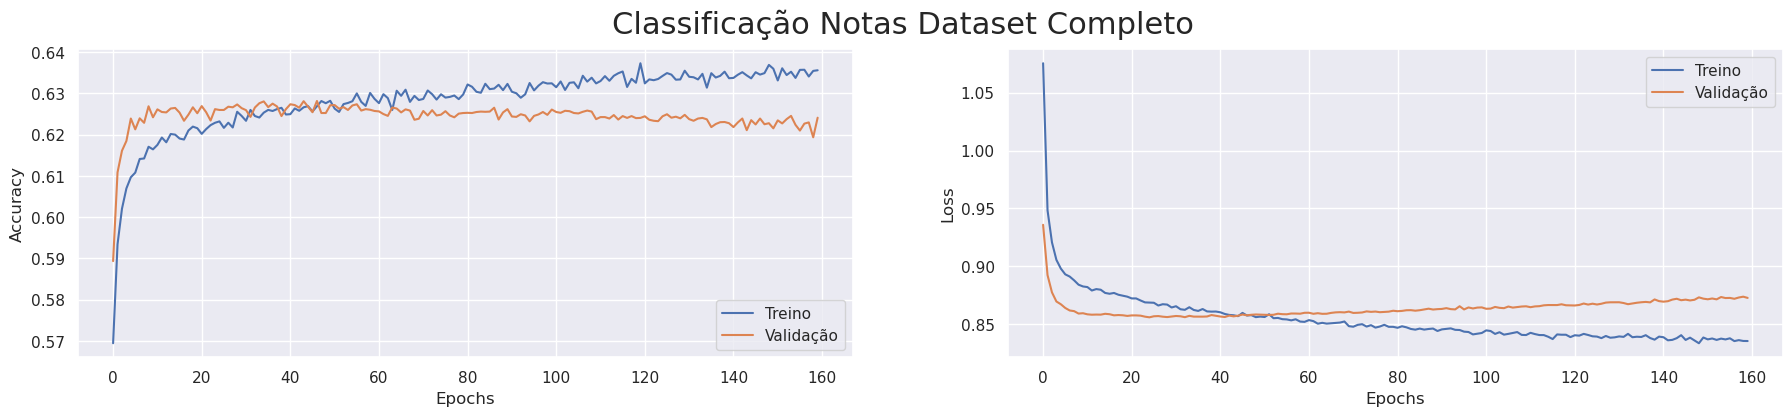

In [208]:
plot_history(history_MLP_notas_complete_dataset,"Classificação Notas Dataset Completo")

In [209]:
#Calculo da acurácia balanceada para avaliar modelo
#comparativo_balanced_acc é um dicionário que vai receber o desempenho do modelo usando diferentes datasets. Os datasets usados serão o completo e undesampled através de diferentes técnicas.

'''
comparativo_balanced_acc={}
y_pred_MLP_complete=np.argmax(MLP_notas_complete_dataset.predict(x_MLP_val_numerico),axis=1)
comparativo_balanced_acc['complete_dataset']=balanced_accuracy_score(np.argmax(y_val_encoded,axis=1),y_pred_MLP_complete)
'''

"\ncomparativo_balanced_acc={}\ny_pred_MLP_complete=np.argmax(MLP_notas_complete_dataset.predict(x_MLP_val_numerico),axis=1)\ncomparativo_balanced_acc['complete_dataset']=balanced_accuracy_score(np.argmax(y_val_encoded,axis=1),y_pred_MLP_complete)\n"

In [210]:
def plotar_confusion_matrix(modelo_complete,
                            modelo_weighted,modelo_undersampled,
                            x,y,classes):
    
    fig,axis=plt.subplots(nrows=1,ncols=3)
    y_pred_complete    =modelo_complete.predict(x)
    y_pred_undersampled=modelo_undersampled.predict(x)
    y_pred_weighted    =modelo_weighted.predict(x)

    cm_complete    =confusion_matrix(np.argmax(y,axis=1),np.argmax(y_pred_complete,axis=1))
    cm_undersampled=confusion_matrix(np.argmax(y,axis=1),np.argmax(y_pred_undersampled,axis=1))
    cm_weighted    =confusion_matrix(np.argmax(y,axis=1),np.argmax(y_pred_weighted,axis=1))

    cm_title=[(cm_complete    ,'Dataset Completo'),
              (cm_weighted   ,'Pesos diferentes para cada classe')
              (cm_undersampled,'Undersampled Dataset')]
    
    cont=0
    for cm, title in cm_title:
        plot_confusion_matrix(conf_mat=cm,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes,
                                axis=axis[cont])
        axis[cont].set_title(title)
        cont+=1
    
    


<>:15: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
<>:15: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
/tmp/ipykernel_5218/547314019.py:15: SyntaxWarning: 'tuple' object is not callable; perhaps you missed a comma?
  (cm_weighted   ,'Pesos diferentes para cada classe')


### Lidando com Dataset Desbalanceado

Serão testados dois método para lidar com o desbalanceamento do dataset:

- undersampling para balancear o número de amostras de cada classe;
- cost sensitive. Esse método consiste em alterar o peso das amostras de cada classe na função de custo.

#### Undersampled Dataset

In [211]:
#Treinar modelo usando diferetes técnicas de undersampling para comparar o desempenho
path_model='../models/MLP_notas_undersampled_dataset.keras'
path_history='../models/history_MLP_notas_undersampled_dataset.pkl'
path_datasets='/home/rodolfo/Insync/rodolfopcruz2@gmail.com/Google Drive/Estudo/Python_Projects/Trip_Advisor/lemman/undersampled/'

def comparavivo_datasets(tecnicas_us,path_model,path_history,path_datasets,neurons=[30,30],resultado={}):
    for technique in tecnicas_us.keys():
        x_MLP_treino_undersampled_numerico=np.load(path_datasets+technique+'/x_MLP_undersampled_'+technique+'.npy')
        y_treino_notas_undersampled=np.load(path_datasets+technique+'/y_MLP_undersampled_'+technique+'.npy')
        #print(path+technique+'/x_MLP_undersampled_'+technique+'.npy')
        #print(path+technique+'/y_MLP_undersampled_'+technique+'.npy')

        MLP_notas=criar_MLP(neurons,activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_notas,name='MLP_notas',lr=lr,dropout_rate=0.3)
        train_model=True


        MLP_notas_undersampled_dataset,history_MLP_notas_undersampled_dataset=train_MLP(train=train_model,model=MLP_notas,save_model=True, 
                x_treino=x_MLP_treino_undersampled_numerico,y_treino=y_treino_notas_undersampled,
                x_val=x_MLP_val_numerico,y_val=y_val_notas,callback=[callback],path_model=path_model,path_history=path_history)

        train_model=False

        MLP_notas_undersampled_dataset,history_MLP_notas_undersampled_dataset=train_MLP(train=train_model,model=MLP_notas,save_model=True, 
                x_treino=x_MLP_treino_undersampled_numerico,y_treino=y_treino_notas_undersampled,
                x_val=x_MLP_val_numerico,y_val=y_val_notas,callback=[callback],path_model=path_model,path_history=path_history)
    
        y_pred=np.argmax(MLP_notas_undersampled_dataset.predict(x_MLP_val_numerico),axis=1)
        resultado[technique]=balanced_accuracy_score(np.argmax(y_val_encoded,axis=1),y_pred)
    return resultado

'''
comparativo_balanced_acc=comparavivo_datasets(tecnicas_us=us_techniques,
                                              path_model=path_model,
                                              path_history=path_history,
                                              path_datasets=path_datasets, 
                                              neurons=[30,30],
                                              resultado=comparativo_balanced_acc)
'''

'\ncomparativo_balanced_acc=comparavivo_datasets(tecnicas_us=us_techniques,\n                                              path_model=path_model,\n                                              path_history=path_history,\n                                              path_datasets=path_datasets, \n                                              neurons=[30,30],\n                                              resultado=comparativo_balanced_acc)\n'

#### Class weights

In [212]:
#Calculo dos pesos de cada classe
notas=[1,2,3,4,5]
class_weights={}
for nota in notas:
    class_weights[str(nota-1)]=(1/sum(y_treino['nota']==nota))*(len(y_treino)/len(notas))


In [213]:
#Treinar modelo

path_model='../models/MLP_notas_complete_dataset_weighted.keras'
path_history='../models/history_MLP_notas_complete_dataset_weighted.pkl'


MLP_notas=criar_MLP([10,10],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_notas,name='MLP_notas',lr=lr,dropout_rate=0.3)

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=False

MLP_notas_complete_dataset_weighted,history_MLP_notas_complete_dataset_weighted=train_MLP(train=train_model,model=MLP_notas,save_model=True, 
                x_treino=x_MLP_treino_numerico,y_treino=y_treino_notas,
                x_val=x_MLP_val_numerico,y_val=y_val_notas,callback=[callback],path_model=path_model,path_history=path_history,class_weights=class_weights)



[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff88a89d730>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff8d0b3cd00>]


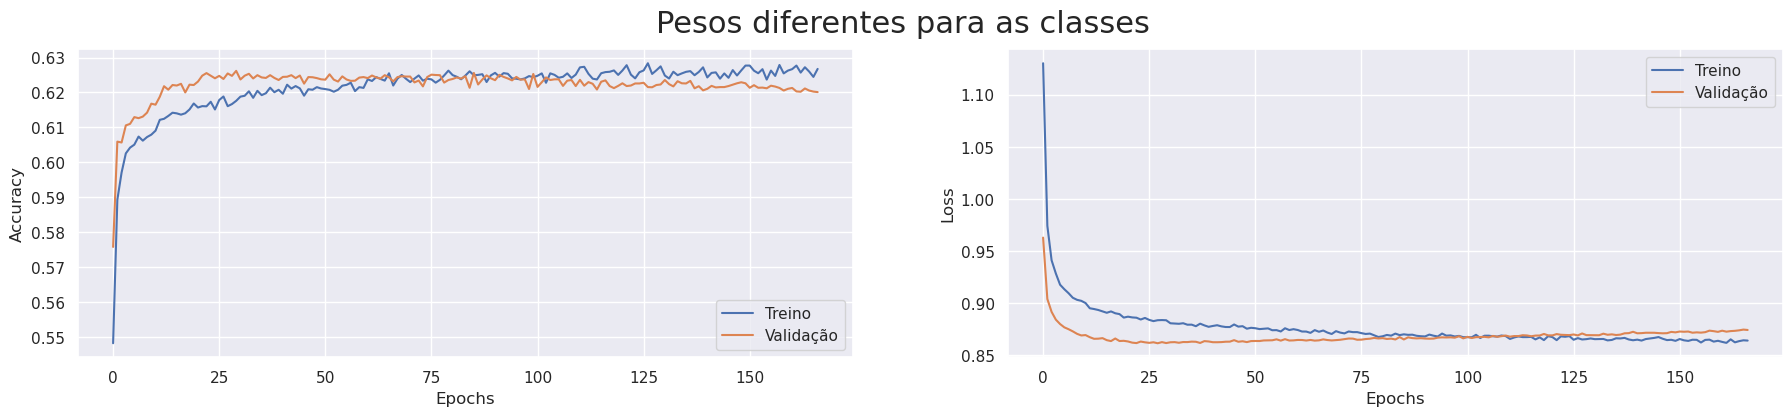

In [214]:
plot_history(history_MLP_notas_complete_dataset_weighted,'Pesos diferentes para as classes')

In [215]:
y_pred=MLP_notas_complete_dataset_weighted.predict(x_MLP_teste_numerico)

506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [216]:
#y_pred_MLP__wieghted=np.argmax(MLP_notas_complete_dataset_weighted.predict(x_MLP_val_numerico),axis=1)
#comparativo_balanced_acc['complete_weighted']=balanced_accuracy_score(np.argmax(y_val_encoded,axis=1),y_pred_MLP_complete)
#comparativo=pd.DataFrame.from_dict(comparativo_balanced_acc,orient='index')
#comparativo.columns=['Balanced Accuracy']

#### Comparativo

In [217]:
#comparativo.to_pickle('../comparativo_MLP_notas.pkl')
comparativo=pd.read_pickle('../comparativo_MLP_notas.pkl')

In [218]:
comparativo

,Balanced Accuracy
complete_dataset,0.377110
ru,0.464348
cnn,0.427115
all_knn,0.369449
enn,0.362857
oss,0.391508
renn,0.361709
tl,0.396355
complete_weighted,0.377110


<Axes: xlabel='None', ylabel='Balanced Accuracy'>

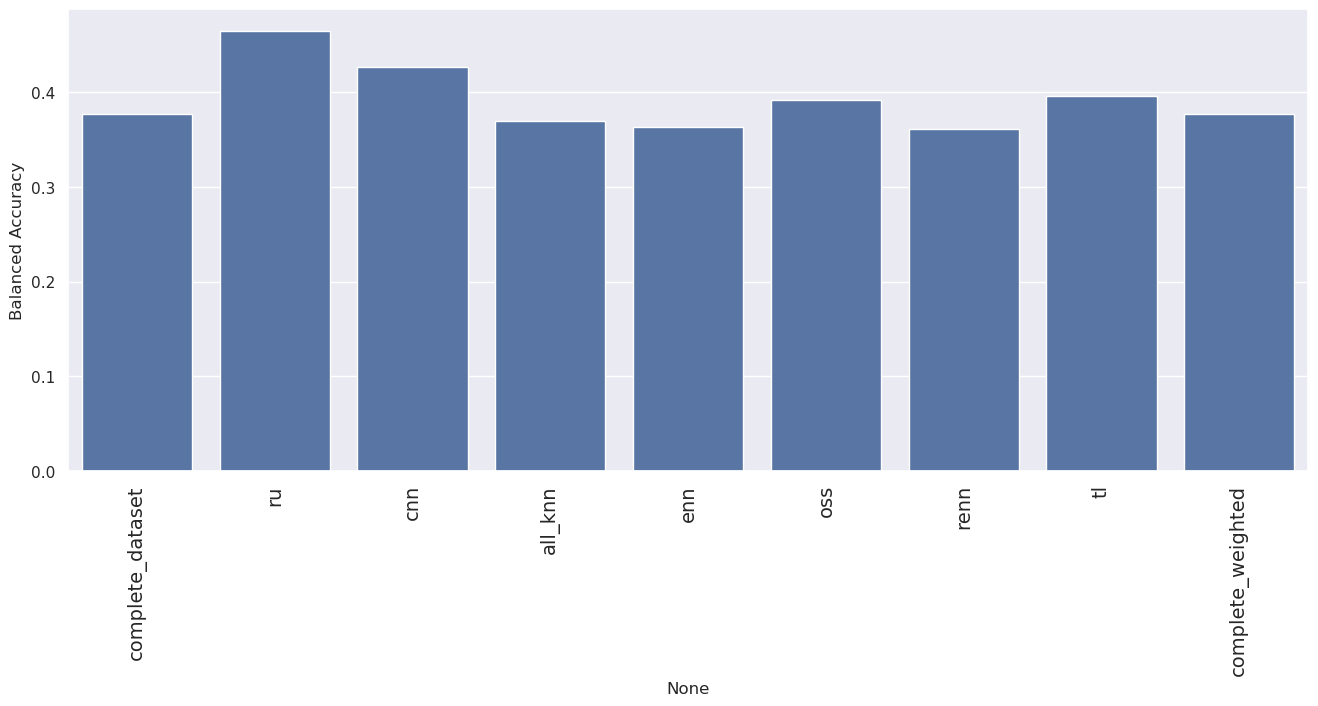

In [219]:
plt.figure(figsize=(16,6))
#sns.set_theme(style='darkgrid')
plt.xticks(rotation=90,fontsize=14)
sns.barplot(data=comparativo,y='Balanced Accuracy',x=comparativo.index,color=None)

O modelo com o melhor resultado foi o treinado com o dataset balanceado usando random undersampling.

In [220]:
n_outpus_notas=y_treino_notas.shape[1]
lr=0.001
MLP_notas=criar_MLP([34,34],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_notas,name='MLP_notas',lr=lr,dropout_rate=0.3)


In [221]:
x_MLP_treino_numerico_undersampled,y_treino_notas_undersampled=us_techniques['ru'].fit_resample(
                                                    x_MLP_treino_numerico,y_treino_notas)


In [222]:
path_model='../models/MLP_notas_undersampled_dataset.keras'
path_history='../models/history_MLP_notas_undersampled_dataset.pkl'

train_model=False

MLP_notas_undersampled_dataset,history_MLP_notas_undersampled_dataset=train_MLP(train=train_model,model=MLP_notas,save_model=True, 
                x_treino=x_MLP_treino_numerico_undersampled,y_treino=y_treino_notas_undersampled,
                x_val=x_MLP_val_numerico,y_val=y_val_notas,callback=[callback],path_model=path_model,path_history=path_history)



[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff88a89d730>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff8d7d43730>]


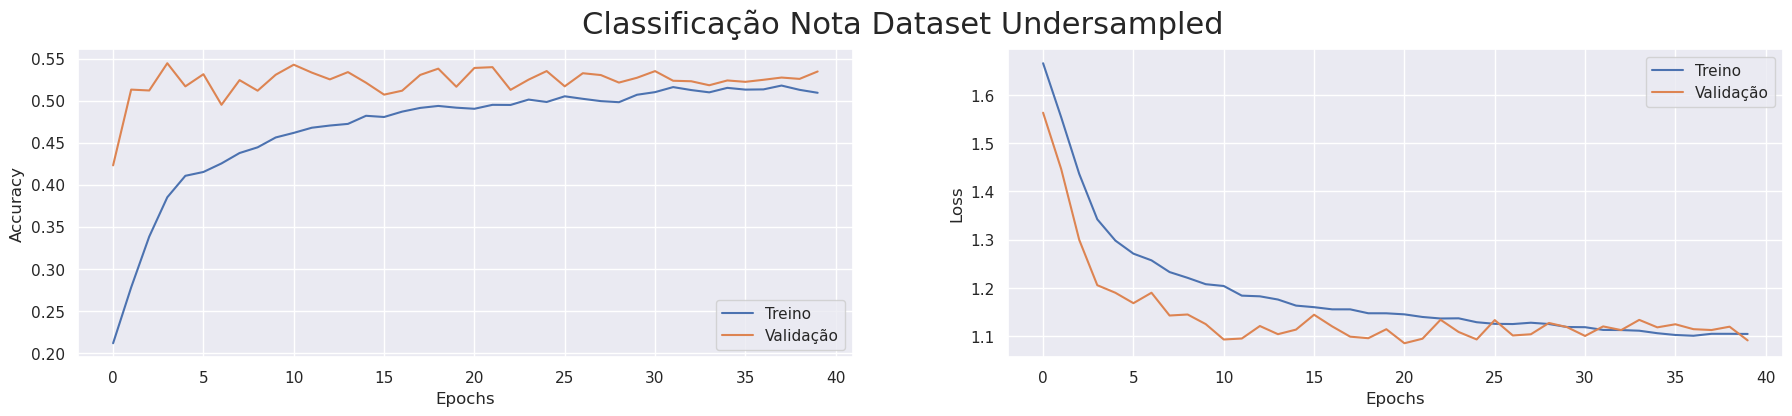

In [223]:
plot_history(history_MLP_notas_undersampled_dataset,'Classificação Nota Dataset Undersampled')

### Resultados

In [224]:
def calcular_metricas(modelo_complete_dataset,modelo_weighted,
                      modelo_undersampled_dataset,x_teste,y_teste):
    resultados={}
    y_pred_completo     = np.argmax(modelo_complete_dataset.predict(x_teste),axis=1)
    y_pred_weighted     = np.argmax(modelo_weighted.predict(x_teste),axis=1)
    y_pred_undersampled = np.argmax(modelo_undersampled_dataset.predict(x_teste),axis=1)
   
    y_teste=np.argmax(y_teste,axis=1)

    
    resultados['acc_complete']             =accuracy_score(y_teste,y_pred_completo)
    resultados['acc_weighted']             =accuracy_score(y_teste,y_pred_weighted)
    resultados['acc_undersampled']         =accuracy_score(y_teste,y_pred_undersampled)
    

    resultados['balanced_acc_complete']    =balanced_accuracy_score(y_teste,y_pred_completo)
    resultados['balanced_acc_weighted']    =balanced_accuracy_score(y_teste,y_pred_weighted)
    resultados['balanced_acc_undersampled']=balanced_accuracy_score(y_teste,y_pred_undersampled)

    return resultados

    

In [225]:
def calcular_precision_recall(modelo_complete,modelo_weighted,modelo_undersampled,x_teste,y_teste,classes):
    
    y_pred_complete    =modelo_complete.predict(x_teste)
    y_pred_weighted    =modelo_weighted.predict(x_teste)
    y_pred_undersampled=modelo_undersampled.predict(x_teste)

    cm_complete    =confusion_matrix(np.argmax(y_teste,axis=1),np.argmax(y_pred_complete,axis=1))
    cm_weighted    =confusion_matrix(np.argmax(y_teste,axis=1),np.argmax(y_pred_weighted,axis=1))
    cm_undersampled=confusion_matrix(np.argmax(y_teste,axis=1),np.argmax(y_pred_undersampled,axis=1))
    cm=[cm_complete,cm_weighted,cm_undersampled]
    modelos=['complete dataset','weighted_classes','undersampled']

    episilon=1e-10

    resultado={}
    for num_modelo in range(len(modelos)):
        #resultado[modelos[num_modelo]]={}
        #resultado[modelos[num_modelo]]['precision']=np.diagonal(cm[num_modelo])/(np.sum(cm[num_modelo],axis=0)+episilon)
        #resultado[modelos[num_modelo]]['recall']   =np.diagonal(cm[num_modelo])/(np.sum(cm[num_modelo],axis=1)+episilon)

        resultado[(modelos[num_modelo],'precision')]=np.diagonal(cm[num_modelo])/(np.sum(cm[num_modelo],axis=0)+episilon)
        resultado[(modelos[num_modelo],'recall')]   =np.diagonal(cm[num_modelo])/(np.sum(cm[num_modelo],axis=1)+episilon)

    resultado=pd.DataFrame(resultado).transpose()
    resultado.columns=classes
    return resultado


In [226]:
def plotar_confusion_matrix(modelo_complete,
                            modelo_weighted,modelo_undersampled,
                            x,y,classes):
    
    fig,axis=plt.subplots(nrows=1,ncols=3,figsize=(22,8))
    y_pred_complete    =modelo_complete.predict(x)
    y_pred_weighted    =modelo_weighted.predict(x)
    y_pred_undersampled=modelo_undersampled.predict(x)
    
    cm_complete    =confusion_matrix(np.argmax(y,axis=1),np.argmax(y_pred_complete,axis=1))
    cm_weighted    =confusion_matrix(np.argmax(y,axis=1),np.argmax(y_pred_weighted,axis=1))
    cm_undersampled=confusion_matrix(np.argmax(y,axis=1),np.argmax(y_pred_undersampled,axis=1))


    cm_title=[(cm_complete    ,'Dataset Completo'),
              (cm_weighted    ,'Pesos diferentes para cada classe'),
              (cm_undersampled,'Undersampled Dataset')]
    
    cont=0
    for (cm,title) in cm_title:
        plot_confusion_matrix(conf_mat=cm,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes,
                                axis=axis[cont])
        axis[cont].set_title(title)
        cont+=1
    
    


In [227]:
resultados_accuracy=calcular_metricas(MLP_notas_complete_dataset,MLP_notas_complete_dataset_weighted,MLP_notas_undersampled_dataset,
                             x_MLP_teste_numerico,y_teste_notas)
resultados_accuracy


506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


{'acc_complete': 0.6226520019772614,
 'acc_weighted': 0.620365793376174,
 'acc_undersampled': 0.5294735541275334,
 'balanced_acc_complete': 0.39409574207348663,
 'balanced_acc_weighted': 0.3636918272847049,
 'balanced_acc_undersampled': 0.4758278457702622}

In [228]:
classes_notas=['Nota_1','Nota_2','Nota_3','Nota_4','Nota_5']
resultados_precision_recall=calcular_precision_recall(MLP_notas_complete_dataset,MLP_notas_complete_dataset_weighted,MLP_notas_undersampled_dataset,
                             x_MLP_teste_numerico,y_teste_notas,classes_notas)
resultados_precision_recall

506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Nota_1    Nota_2    Nota_3    Nota_4    Nota_5
complete dataset precision  0.355556  0.000000  0.395564  0.452142  0.691566
                 recall     0.500000  0.000000  0.368119  0.199161  0.903198
weighted_classes precision  0.436548  0.000000  0.403756  0.406427  0.680308
                 recall     0.447917  0.000000  0.246560  0.200326  0.923657
undersampled     precision  0.284785  0.161318  0.278968  0.365775  0.778367
                 recall     0.570312  0.401261  0.440367  0.318658  0.648541

506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


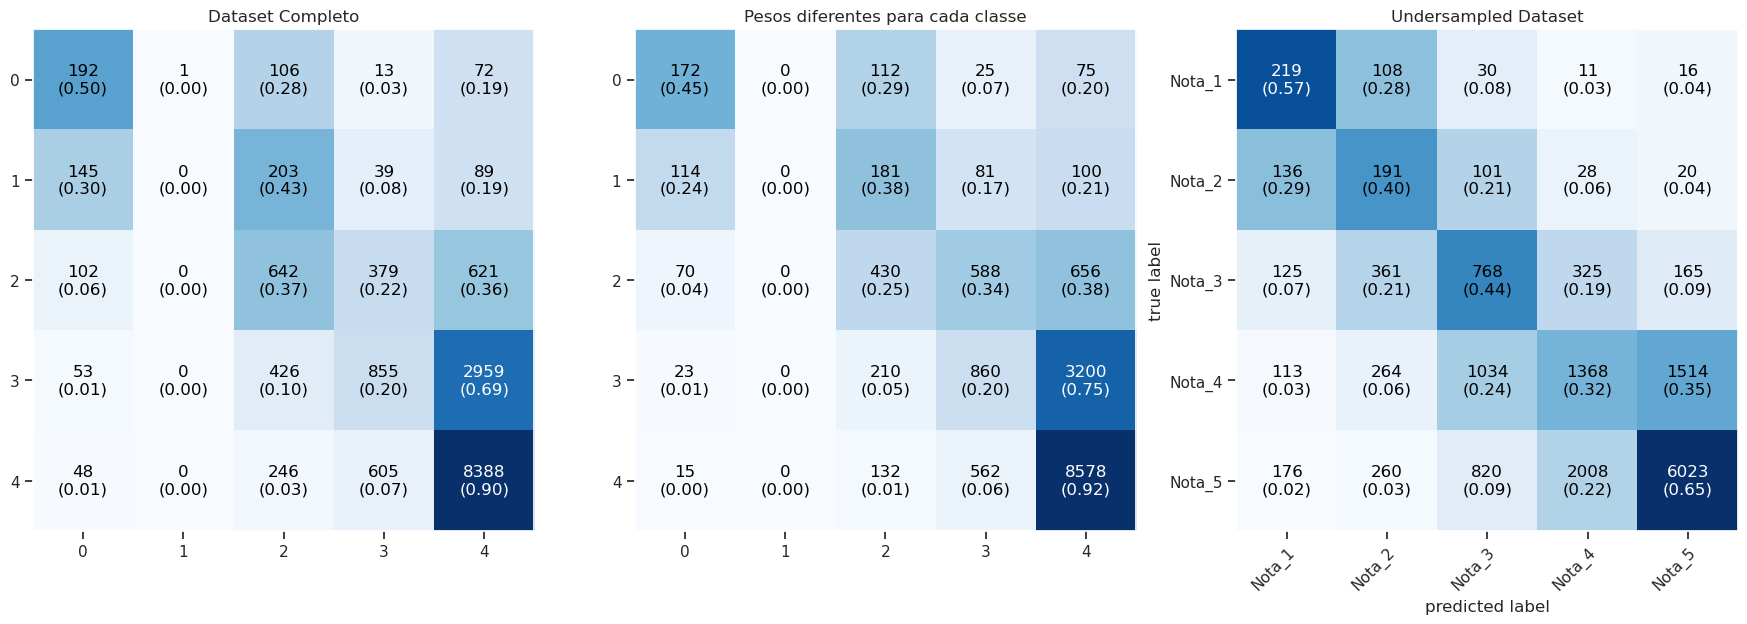

In [229]:
plotar_confusion_matrix(MLP_notas_complete_dataset,MLP_notas_complete_dataset_weighted,MLP_notas_undersampled_dataset,
                    x_MLP_teste_numerico,y_teste_notas,classes_notas)

A presença ou ausência de certas palavras não é informação suficiente para identificar a nota do comentário. Analisando  matriz de confusão, 70% das amostras com nota 4 foram classificadas como nota 5. O motivo para é a presença de palavras com conotação positiva nos comentários com amabas as notas. Uma grande proporção de comentários com notas 1 e 2 foram erroneamente classificados como nota 3. Até mesmo uma proporção de comentários com nota 1 foram erronemente classificados como nota 5. O motivo para esses erros foi verificado na aálise dos comentários, onde verificou-se a presença de palavras com conotação extremamente positiva (como maravilhoso por exemplo) em comentários com nota 1.

## Rede para classificar os comentários como positivos, negativos e neutros

Os dados de entrada são os mesmos da rede neural MLP para classificação das notas. É necessário somente fazer a conversão das notas: comentários com notas 4 e 5 serão considerados positivos, nota 3 neutros, enquantos os notas 1 e 2 negativos. 

In [230]:
#Conversão das saidas para rede
#Conversao das notas para negativo,neutro e positivo
y_treino_ternario             =np.argmax(y_treino_encoded,axis=1)+1
y_val_ternario                =np.argmax(y_val_encoded,axis=1)+1
y_teste_ternario              =np.argmax(y_teste_encoded,axis=1)+1



In [231]:
def converter_ternario(x):
    if x==5 or x==4: return 2
    elif x==3      : return 1
    else           : return 0

func = np.vectorize(converter_ternario)

In [232]:
y_treino_ternario              =func(y_treino_ternario).reshape([-1,1])
y_val_ternario                 =func(y_val_ternario).reshape([-1,1])
y_teste_ternario               =func(y_teste_ternario).reshape([-1,1])

In [233]:
y_treino_ternario              = encoder.fit_transform(y_treino_ternario)
y_val_ternario                 = encoder.fit_transform(y_val_ternario)
y_teste_ternario               = encoder.fit_transform(y_teste_ternario)

#np.save('../y_treino_ternario.npy',y_treino_ternario)
#np.save('../y_treino_ternario_undersampled.npy',y_treino_ternario_undersampled)
#np.save('../y_val_ternario.npy',y_val_ternario)
#np.save('../y_teste_ternario.npy',y_teste_ternario)

### Treinamento com dataset completo

In [234]:
n_outpus_ternario=y_treino_ternario.shape[1]
lr=0.001
MLP_ternaria=criar_MLP([10,10],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_ternario,name='MLP_ternaria',lr=lr,dropout_rate=0.3)

#Treinar modelo
path_model='../models/MLP_ternaria_complete_dataset.keras'
path_history='../models/history_MLP_ternaria_complete_dataset.pkl'

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=False

MLP_ternaria_complete_dataset,history_MLP_ternaria_complete_dataset=train_MLP(train=train_model,model=MLP_ternaria,save_model=True, 
                x_treino=x_MLP_treino_numerico,y_treino=y_treino_ternario,
                x_val=x_MLP_val_numerico,y_val=y_val_ternario,callback=[callback],path_model=path_model,path_history=path_history)


[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff8d7cf3bb0>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff88a89d730>]


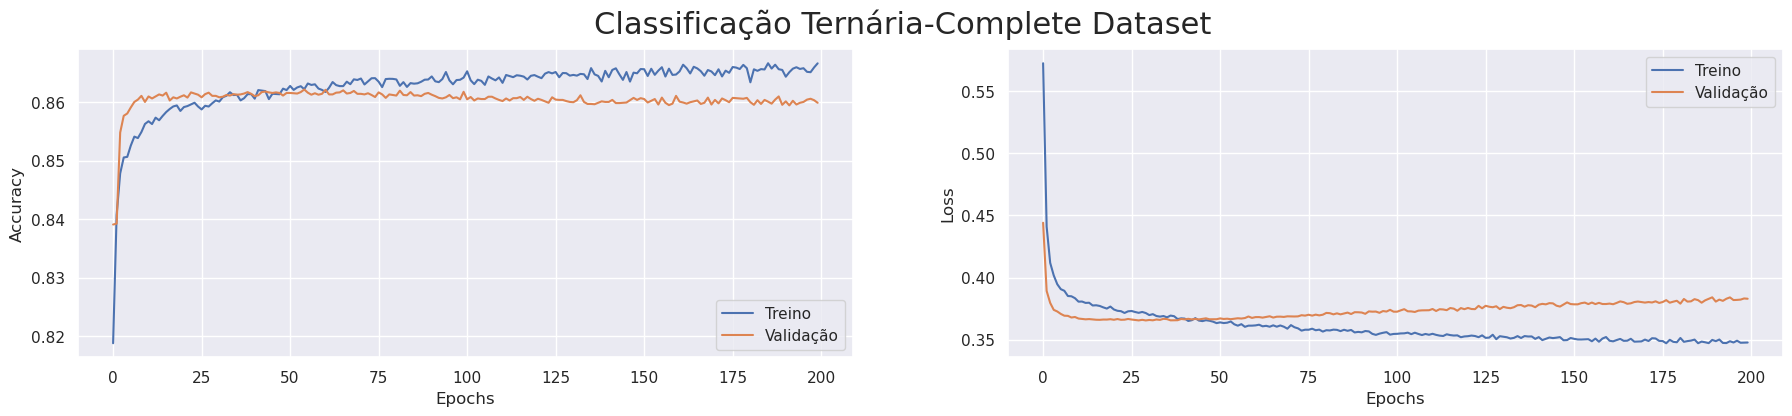

In [235]:
plot_history(history_MLP_ternaria_complete_dataset, 'Classificação Ternária-Complete Dataset')

### Treinamento com undersampled dataset

In [236]:
n_outpus_ternario=y_treino_ternario.shape[1]
lr=0.001
MLP_ternaria=criar_MLP([12,12],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_ternario,name='MLP_ternaria',lr=lr,dropout_rate=0.3)

#Undersample dataset
x_MLP_treino_numerico_undersampled,y_treino_ternario_undersampled=us_techniques['ru'].fit_resample(
                            x_MLP_treino_numerico,y_treino_ternario)


#Treinar modelo
path_model='../models/MLP_ternaria_undersampled_dataset.keras'
path_history='../models/history_MLP_undersampled_complete_dataset.pkl'

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=False

MLP_ternaria_undersampled_dataset,history_MLP_ternaria_undersampled_dataset=train_MLP(train=train_model,model=MLP_ternaria,save_model=True, 
                x_treino=x_MLP_treino_numerico_undersampled,y_treino=y_treino_ternario_undersampled,
                x_val=x_MLP_val_numerico,y_val=y_val_ternario,callback=[callback],path_model=path_model,path_history=path_history)


[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff8d7e91e80>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff8d7cf3bb0>]


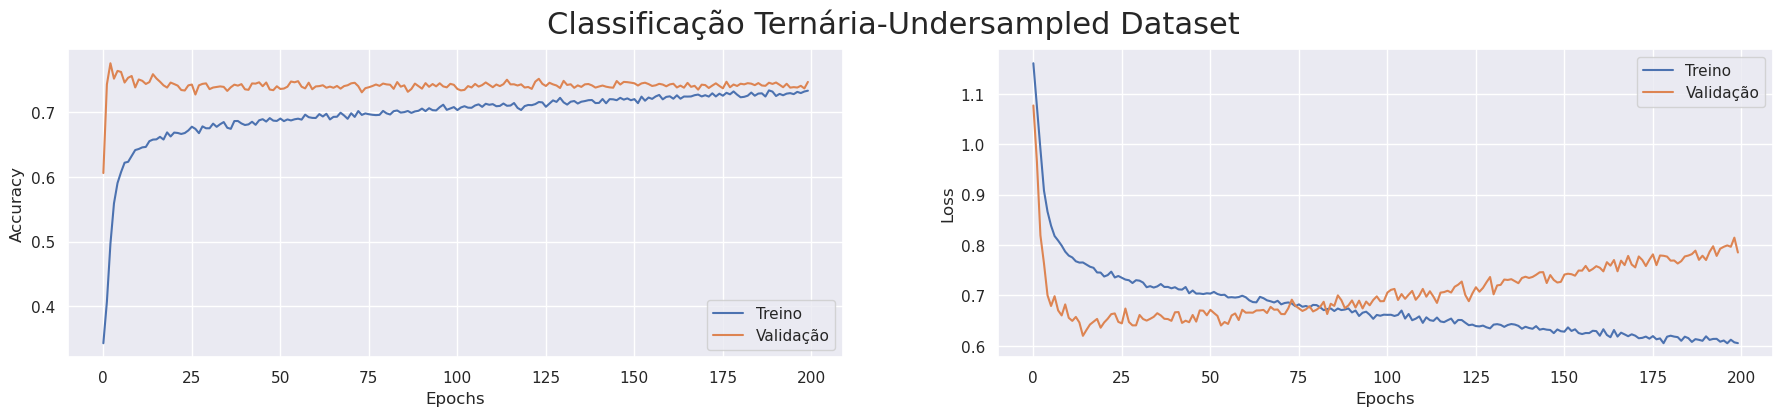

In [237]:
plot_history(history_MLP_ternaria_undersampled_dataset, 'Classificação Ternária-Undersampled Dataset')

### Treinamento pesos diferentes as classes

In [238]:
notas=[1,2,3,4,5]
class_weights={}
for nota in notas:
    class_weights[str(nota-1)]=(1/sum(y_treino['nota']==nota))*(len(y_treino)/5)

In [239]:
y_ternario=np.argmax(y_treino_ternario,axis=1)
avaliacoes=[0,1,2] #avaliacoes correspondem a negativo, neutro e positivo
class_weights_aval={}
for avaliacao in avaliacoes:
    class_weights_aval[str(avaliacao)]=(1/sum(y_ternario==avaliacao))*(len(y_ternario)/len(avaliacoes))
class_weights_aval

{'0': 6.274304545895124, '1': 3.092194516098213, '2': 0.3972628801129215}

In [240]:
n_outpus_ternario=y_treino_ternario.shape[1]
lr=0.001
MLP_ternaria=criar_MLP([10,10],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_ternario,name='MLP_ternaria',lr=lr,dropout_rate=0.3)

#Treinar modelo
path_model='../models/MLP_ternaria_weighted.keras'
path_history='../models/history_MLP_ternaria_weighted.pkl'

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=False

MLP_ternaria_weighted,history_MLP_ternaria_weighted=train_MLP(train=train_model,model=MLP_ternaria,save_model=True, 
                x_treino=x_MLP_treino_numerico,y_treino=y_treino_ternario,
                x_val=x_MLP_val_numerico,y_val=y_val_ternario,callback=[callback],path_model=path_model,path_history=path_history,class_weights=class_weights_aval)


[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff88a92c040>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff8d7e91e80>]


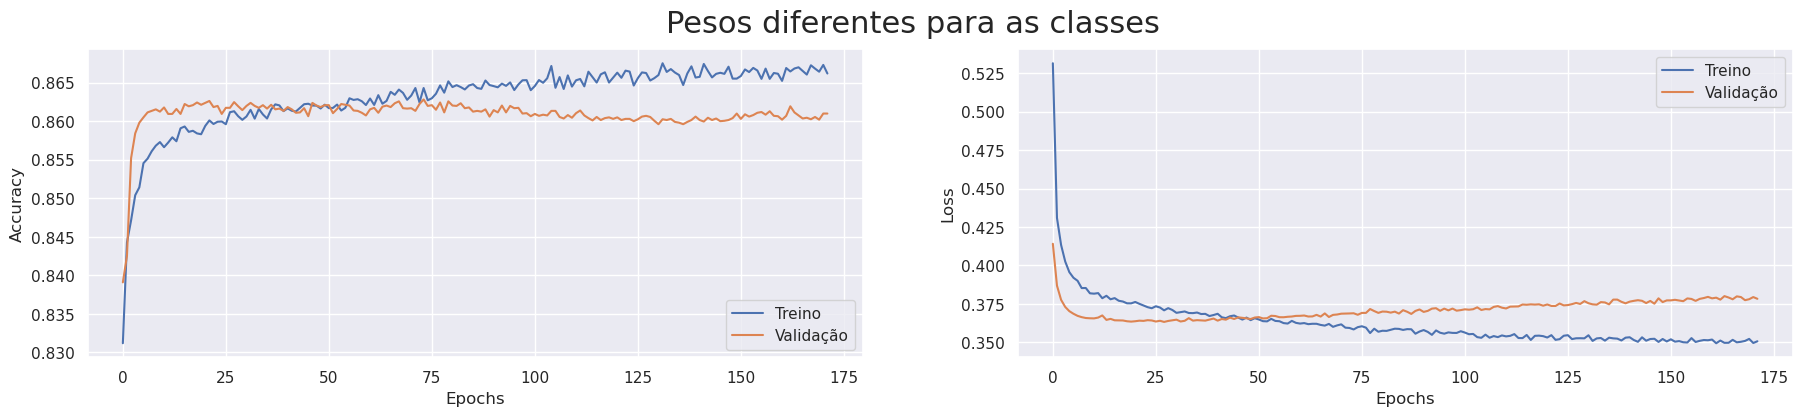

In [241]:
plot_history(history_MLP_ternaria_weighted,'Pesos diferentes para as classes')

### Resultados

In [243]:
resultados_MLP_ternaria_accuracy=calcular_metricas(MLP_ternaria_complete_dataset,
                             MLP_ternaria_weighted,MLP_ternaria_undersampled_dataset,
                             x_MLP_teste_numerico,y_teste_ternario)
resultados_MLP_ternaria_accuracy

506/506 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


{'acc_complete': 0.8622095897182402,
 'acc_weighted': 0.8618388531883342,
 'acc_undersampled': 0.7369624320316361,
 'balanced_acc_complete': 0.5093474542701016,
 'balanced_acc_weighted': 0.5107219160487247,
 'balanced_acc_undersampled': 0.6474168804155344}

In [244]:
classes_ternario=['Negativo','Neutro','Positivo']
resultados_precision_recall_MLP_ternaria=calcular_precision_recall(MLP_ternaria_complete_dataset,
                             MLP_ternaria_weighted,MLP_ternaria_undersampled_dataset,
                             x_MLP_teste_numerico,y_teste_ternario,classes_ternario)
resultados_precision_recall_MLP_ternaria

506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


Negativo    Neutro  Positivo
complete dataset precision  0.636953  0.443425  0.880315
                 recall     0.456977  0.083142  0.987923
weighted_classes precision  0.666667  0.420245  0.887587
                 recall     0.393023  0.157110  0.982032
undersampled     precision  0.371127  0.245911  0.951177
                 recall     0.654651  0.517202  0.770398

506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
506/506 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


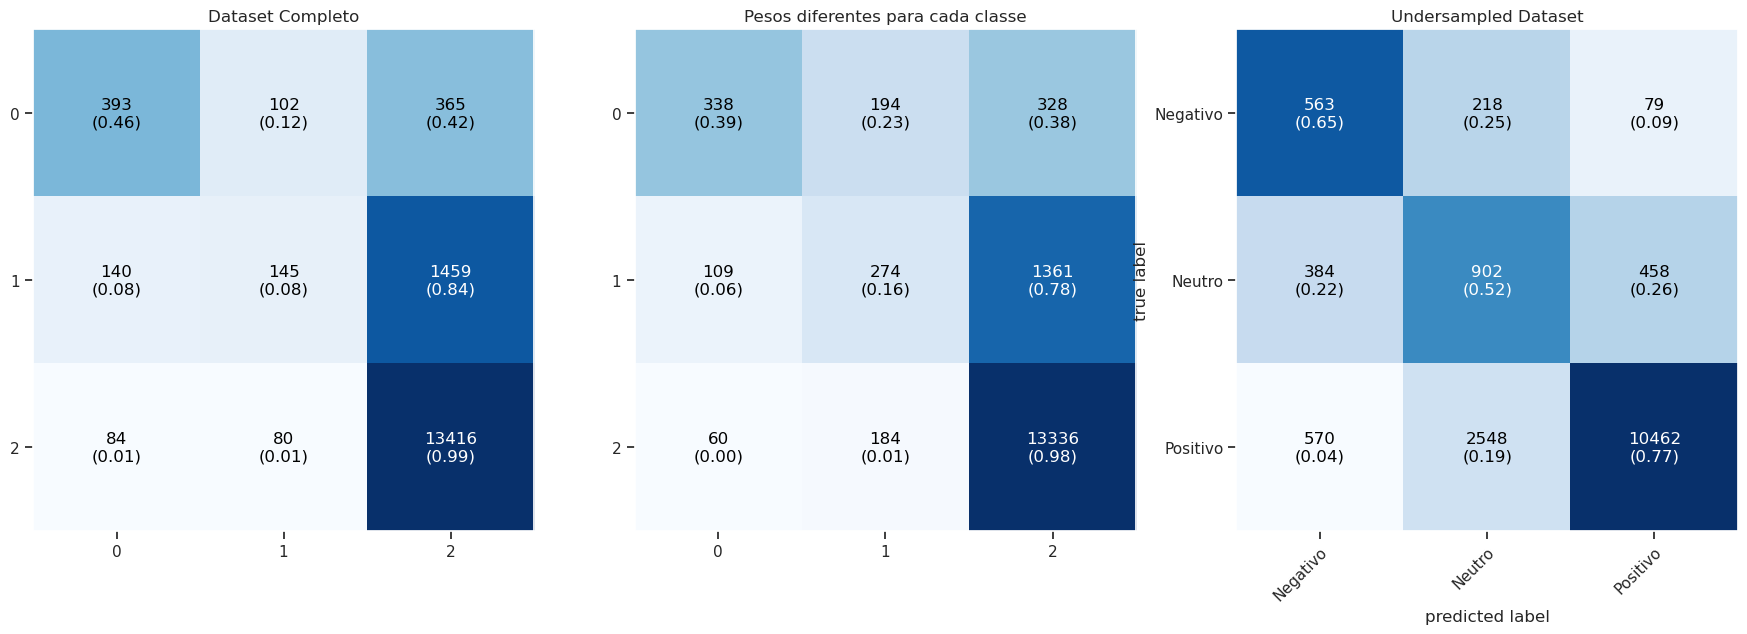

In [245]:
plotar_confusion_matrix(MLP_ternaria_complete_dataset,MLP_ternaria_weighted,MLP_ternaria_undersampled_dataset,
                    x_MLP_teste_numerico,y_teste_ternario,classes_ternario)

Como o dataset é desbalanceado, a acurácia dá a impressão de um resultado melhor do que realmente foi. A maior parte dos acertos foi para as amostras da classe positiva. Para a classe neutra o modelo acertou somente 20% das amostras e para a classe negativa somente 45%.

## Rede para classificar os comentários como positivos e negativos

Comentários com notas 3,4 e 5 serão considerados positivos enquantos os comentários com notas 1 e 2 serão considerados negativos.

### Treinamento com dataset completo

In [247]:
#Converter as saídas da rede

y_treino_binario              =np.argmax(y_treino_encoded,axis=1)+1
y_val_binario                 =np.argmax(y_val_encoded,axis=1)+1
y_teste_binario               =np.argmax(y_teste_encoded,axis=1)

def converter_binario(x):
    return (np.where(x>=3,1,0)).reshape([-1,1])

y_treino_binario             =encoder.fit_transform(converter_binario(y_treino_binario))
y_val_binario                =encoder.fit_transform(converter_binario(y_val_binario))
y_teste_binario              =encoder.fit_transform(converter_binario(y_teste_binario))

#np.save('../binario/y_treino_binario.npy',y_treino_binario)
#np.save('../binario/y_treino_binario_undersampled.npy',y_treino_binario_undersampled)
#np.save('../binario/y_val_binario.npy',y_val_binario)
#np.save('../binario/y_teste_binario.npy',y_teste_binario)

In [250]:
n_outpus_binario=y_treino_binario.shape[1]
lr=0.001
MLP_binaria=criar_MLP([5],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_binario,name='MLP_binaria',lr=lr,dropout_rate=0.3)
#Treinar modelo
path_model='../models/MLP_binaria_weighted.keras'
path_history='../models/history_MLP_binaria_weighted.pkl'

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=True

MLP_binariad,history_MLP_binaria=train_MLP(train=train_model,model=MLP_binaria,save_model=True, 
                x_treino=x_MLP_treino_numerico,y_treino=y_treino_binario,
                x_val=x_MLP_val_numerico,y_val=y_val_binario,callback=[callback],path_model=path_model,path_history=path_history)

[[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ff926cabfd0>], <keras.src.callbacks.model_checkpoint.ModelCheckpoint object at 0x7ff926cb6940>]
Epoch 1/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.7982 - loss: 0.4187 - val_accuracy: 0.9469 - val_loss: 0.1538
Epoch 2/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.9470 - loss: 0.1608 - val_accuracy: 0.9470 - val_loss: 0.1242
Epoch 3/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.9522 - loss: 0.1372 - val_accuracy: 0.9543 - val_loss: 0.1176
Epoch 4/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9538 - loss: 0.1317 - val_accuracy: 0.9557 - val_loss: 0.1155
Epoch 5/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9556 - loss: 0.1280 - val_accuracy: 0.9568 - val_loss: 0.1146
Epoch 6/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9577 - loss: 0.1228 - val_accuracy: 0.9566 - val_loss: 0.1145
Epoch 7/200
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 13s 

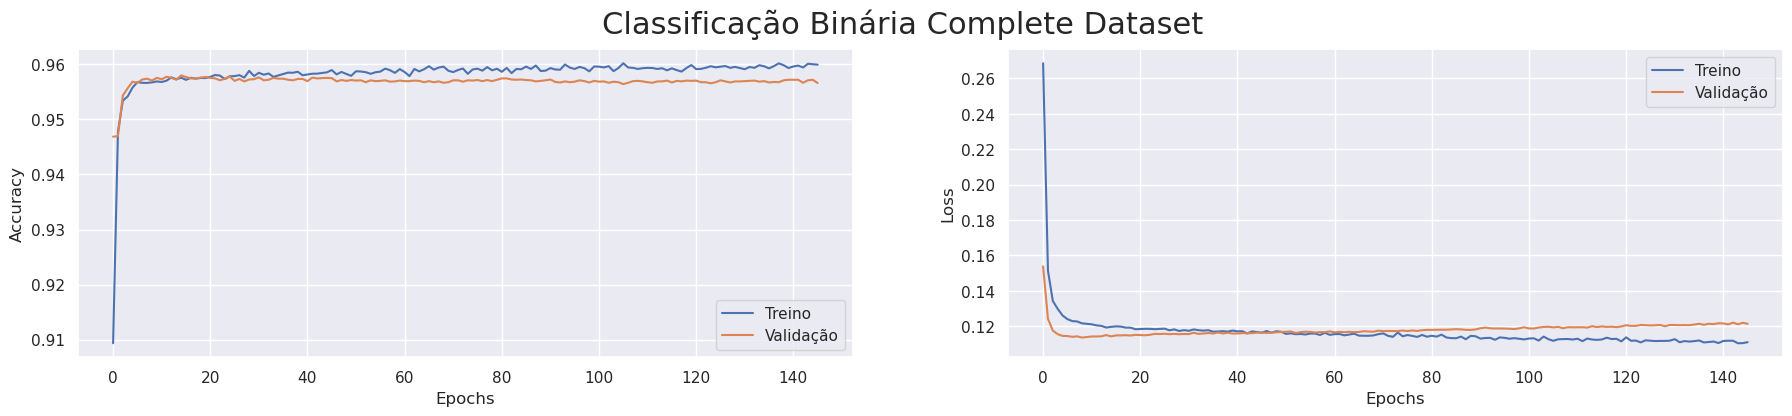

In [251]:
plot_history(history_MLP_binaria, 'Classificação Binária Complete Dataset')

### Treinamento com undersampled dataset

In [213]:
n_outpus_ternario=y_treino_ternario.shape[1]
lr=0.001
MLP_binaria=criar_MLP([5],activation='sigmoid',input_shape=x_MLP_treino_numerico.shape[1:],
                                   n_outputs=n_outpus_ternario,name='MLP_ternaria',lr=lr,dropout_rate=0.3)

#Undersample dataset
x_MLP_treino_numerico_undersampled,y_treino_binario_undersampled=us_techniques['ru'].fit_resample(
                            x_MLP_treino_numerico,y_treino_binario)


#Treinar modelo
path_model='../models/MLP_binaria_undersampled_dataset.keras'
path_history='../models/history_MLP_binaria_undersampled_dataset.pkl'

earlystopping_cb=EarlyStopping(monitor='accuracy',patience=40,restore_best_weights=True) #Early stopping
callback=[earlystopping_cb]

train_model=False

MLP_ternaria_undersampled_dataset,history_MLP_ternaria_undersampled_dataset=train_MLP(train=train_model,model=MLP_ternaria,save_model=True, 
                x_treino=x_MLP_treino_numerico_undersampled,y_treino=y_treino_ternario_undersampled,
                x_val=x_MLP_val_numerico,y_val=y_val_ternario,callback=[callback],path_model=path_model,path_history=path_history)

633/633 [==============================] - 1s 616us/step - loss: 0.1157 - accuracy: 0.9573


[0.11569510400295258, 0.9572890400886536]

### Analisar pesos das camadas

In [214]:
#Pesos da primeira camada fully connected
pesos=neural_net_MLP.layers[1].get_weights()[0]

NameError: name 'neural_net_MLP' is not defined

In [ ]:
positive_word='perfeito'
negative_word='horrível'

In [ ]:
vocab_MLP

{'horrível': 0,
 'desrespeito': 1,
 'lamentável': 2,
 'pandemia': 3,
 'respeito': 4,
 'capacidade': 5,
 'total': 6,
 'vip': 7,
 'descaso': 8,
 'mau': 9,
 'péssimo': 10,
 'interminável': 11,
 'limite': 12,
 'espera': 13,
 'cliente': 14,
 'site': 15,
 'gigantesco': 16,
 'furar': 17,
 'metade': 18,
 'promoção': 19,
 'absurdo': 20,
 'totalmente': 21,
 'gastar': 22,
 'ninguém': 23,
 'pass': 24,
 'condição': 25,
 'atendente': 26,
 'hora': 27,
 'avisar': 28,
 'passaporte': 29,
 'quebrar': 30,
 'experiência': 31,
 'informar': 32,
 'fila': 33,
 'hari': 34,
 'desorganização': 35,
 'paguei': 36,
 'demorar': 37,
 'montanha': 38,
 'decepção': 39,
 'brinquedo': 40,
 'hopi': 41,
 'cheguei': 42,
 'funcionamento': 43,
 'controle': 44,
 'russo': 45,
 'decepcionante': 46,
 'impossível': 47,
 'lotar': 48,
 'meia': 49,
 'ingresso': 50,
 'brincar': 51,
 'conseguir': 52,
 'filho': 53,
 'funcionar': 54,
 'caríssimo': 55,
 'esposo': 56,
 'filha': 57,
 'feio': 58,
 'fast': 59,
 'nenhum': 60,
 'lotado': 61,
 'ab

In [ ]:
def calcular_similaridade(selected_word,weights,return_vectors=False,num_words_vocab=len(vocab_MLP)):
    '''
    Função que calculará a similaridade entre uma palavra e as demais presentes no vacabulário. Para esse cálculo é usado os pesos aprendidos preda rede neural MLP
    
    Inputs:
        selected word (string)  - Palavra que será comparada com as demais no vocabulário
        weights (array)         - Pesos da rede MLP que foram aprendidos no treinamento
        return_vectors (boolean)- Se true retorna vectors e similaridade. Caso contrário, somente similaridade (ver outputs)
        num_words_vocab (int)   - Número de palavras no vocabulário

    Outputs
        similaridade - objeto counter com as similaridades calculadas em relação a todas as palavras presentes no vocabulário
        vectors      - array formado pela multiplicação de cada palavra pelos pesos da rede neural.Cada linha é um vetor referente a uma das palavras.

    '''
    matrix=np.identity(num_words_vocab)
    vectors=np.matmul(matrix,weights)
    similaridade=Counter()
    selected_vector=vectors[vocab_MLP[selected_word]]
    for num_row in range(len(vocab_MLP)):
        similaridade[list(vocab_MLP.keys())[num_row]]=np.dot(selected_vector,vectors[num_row])

    if return_vectors:
        return vectors,similaridade
    else:
        return similaridade
    

In [ ]:
vectors,similar_words_to_positive=calcular_similaridade(positive_word,pesos,return_vectors=True)

In [ ]:
similar_words_to_positive.most_common()

[('iguaçu', 6.802997453668329),
 ('historia', 6.565935073462853),
 ('imperdível', 6.464434216151194),
 ('natureza', 6.083826711093305),
 ('amar', 5.882562025997775),
 ('encantar', 5.779244911928053),
 ('adorar', 5.609511392750694),
 ('perfeito', 5.413490143790476),
 ('ideal', 5.392510946660931),
 ('idade', 5.359541492378131),
 ('maravilhoso', 5.13215212714891),
 ('show', 4.995352456864341),
 ('belíssimo', 4.802113955479744),
 ('erva', 4.798660805870814),
 ('diversidade', 4.541945357461316),
 ('lindo', 4.2952005914612705),
 ('obrigatório', 4.285625602581128),
 ('calçadão', 4.231557034676509),
 ('dica', 4.23035590488726),
 ('época', 4.105348106911396),
 ('ótimo', 4.053103345301052),
 ('organizar', 3.9938152777049325),
 ('catarata', 3.891141694325846),
 ('trilha', 3.8364479260750723),
 ('lojinha', 3.703065653380584),
 ('divertido', 3.700788403503031),
 ('Bahia', 3.6943190712918437),
 ('típico', 3.67158811061425),
 ('centavo', 3.600171425457326),
 ('cultural', 3.528510925934455),
 ('tradic

In [ ]:
similar_words_to_negative=calcular_similaridade(negative_word,pesos)

In [ ]:
similar_words_to_negative.most_common()[-1:-20:-1]

[('iguaçu', -13.389724837461245),
 ('imperdível', -12.964294974537019),
 ('historia', -12.762302417365412),
 ('natureza', -12.160607675117667),
 ('amar', -11.612510231196381),
 ('encantar', -11.606325804469712),
 ('adorar', -11.501412035826412),
 ('idade', -10.93402768764497),
 ('ideal', -10.837052949966491),
 ('perfeito', -10.534366673093047),
 ('maravilhoso', -10.169765028464482),
 ('show', -9.643062737685348),
 ('erva', -9.619470033624651),
 ('belíssimo', -9.396380515605216),
 ('diversidade', -9.16186337958613),
 ('calçadão', -8.666824359834699),
 ('obrigatório', -8.551360064840395),
 ('lindo', -8.526525956595194),
 ('ótimo', -8.245291229370878)]

In [ ]:
pos = 0
neg = 0
colors_list=[]
vobab_list_MLP=[]
for word in vocab_MLP:
    vobab_list_MLP.append(word)
    if (razao_nota5[word]+razao_nota4[word]+razao_nota3[word])>0.5:
        colors_list.append("#00ff00")
        pos+=1
    else:
        colors_list.append("#000000")
        neg+=1
    

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vectors)

/home/rodolfo/anaconda3/envs/Trabalho/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/rodolfo/anaconda3/envs/Trabalho/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [ ]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Clusterização das Palavras")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=vobab_list_MLP,
                                    color=colors_list))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(word_labels)

show(p)
tensorflow
# Em verdes estão palavras que aparecem com maior frequência em comentários positivos enquanto em preto as palavra que aparecem com  maior frequência em comentários negativos

# Modelos para Processamento de Linguagem Natural


## Criação do vocabulário

In [215]:
#Dados que serão usados para o treinamento da LSTM

x_treino_LSTM              =x_treino_lemman
x_treino_LSTM_undersampled =x_treino_undersampled_lemman
x_val_LSTM                 =x_val_lemman
x_teste_LSTM               =x_teste_lemman

In [216]:
def criar_vocabulario(dados_treino, max_words_vocab):
    '''
    Função que cria uma lista com todas as palavram que apareceram no conunto de dados de treino
    Essa lista terá uma palavra para padding e outra para indicar que a palavra não foi encontrada no vocabulário

    <pad> - Foi adicionado em certos comentários para que todos os comentários tenham um mesmo número de comentário
    <oov> - out of vocabulary. Usado para indicar que uma palavra não está no vocabulário

    Inputs:
    dados_treino    - dados que serão usados para o treinamento dos modelos. Numpy array com amostras nas linhas e palavras nas colunas
    max_words_vocab - número máximo de palavras que entrarão no vocabulário.

    '''
    vocab=Counter()
    for i in dados_treino:
        vocab.update(i)
    vocab=[word for word, count in vocab.most_common()[:max_words_vocab]]
    vocab=vocab+['oov']
    return vocab


In [217]:
#Os dados de treinamento para as LSTM serão o indexes de cada palavra no vocabulário criado

def converter_tokens_LSTM(dados_tokens,vocab):
    num_rows,num_cols=np.shape(dados_tokens)
    dados_numericos=np.zeros([num_rows,num_cols])
    for row in range(num_rows):
        for col in range(num_cols):
            if dados_tokens[row,col] in vocab:
                dados_numericos[row,col]=vocab.index(dados_tokens[row,col])
        else:
            dados_numericos[row,col]=vocab.index('oov')
    return dados_numericos


In [218]:
vocab_size=1000
vocab_LSTM=criar_vocabulario(x_treino_LSTM,vocab_size)

In [219]:
x_LSTM_treino_numerico              =converter_tokens_LSTM(x_treino_LSTM,vocab_LSTM)
x_LSTM_treino_undersampled_numerico =converter_tokens_LSTM(x_treino_LSTM_undersampled,vocab_LSTM)
x_LSTM_val_numerico                 =converter_tokens_LSTM(x_val_LSTM,vocab_LSTM)
x_LSTM_teste_numerico               =converter_tokens_LSTM(x_teste_LSTM,vocab_LSTM)

## Criação do modelo

In [220]:
#Função que implementa o mecanismo de atenção de Luong
def attention_Luong(c):
  c[1]=tf.expand_dims(c[1],axis=-1)
  attention_weights=tf.matmul(c[0],c[1])
  attention_weights=tf.nn.softmax(attention_weights,axis=1)
  context_vector=c[0]*attention_weights
  context_vector=tf.reduce_sum(context_vector,axis=1)
  return context_vector

In [221]:
def criar_LSTM(neurons,embedding_size,sequence_length,num_words_vocab,n_outputs,name,attention=True,lr=0.001,loss='categorical_crossentropy',dropout_rate=0.2):
    """
    Função para criação de um MLP

    inputs -
    neurons          - Lista com número de neurônios nas hidden layers
    num_words        - (int) Número de palavras no vocabulário
    embedding_size   - (int) Número de dimensões geradas pela embedding layer
    sequence_length  - (int) Comprimento das sequências
    input_shape      - (int) shape dos dados de entrada
    n_outputs        - (int) número de saídas geradas pela rede
    name             - (string) nome do modelo
    lr               -  learning rate
    loss             - (string) loss
    attention        - (boolean) Usar ou não mecanismo de atenção 
    """
    x_in=x=Input(shape=sequence_length)
    x=Embedding(input_dim=num_words_vocab,output_dim=embedding_size)(x)
    for num_camada,num_neurons in enumerate(neurons[:-1]):
        x=Bidirectional(LSTM(units=num_neurons,dropout=dropout_rate,return_sequences=True),name='Bidirectional_LSTM_'+str(num_camada),merge_mode='concat')(x)
    if attention:
        (x, forward_h, forward_c, backward_h, backward_c) =Bidirectional(LSTM(units=neurons[-1],dropout=dropout_rate,return_state=True,return_sequences=True),
                                                                         name='Bidirectional_LSTM_'+str(num_camada+1),merge_mode='concat')(x)
        state_h=Concatenate()([forward_h,backward_h])
        x_last=Lambda(attention_Luong)([x,state_h])
    else:
        x_last=Bidirectional(LSTM(units=neurons[-1],dropout=dropout_rate),name='Bidirectional_LSTM_'+str(num_camada+1),merge_mode='concat')(x)

    x_out=Dense(n_outputs,activation='softmax')(x_last)

    model=Model(inputs=x_in,outputs=x_out,name=name)
    model.compile(loss=loss,optimizer='adam',metrics=['accuracy'])
    return model
    



In [224]:
neurons_list        =[1,1,1]
embedding_size=100
sequence_lengh=np.shape(x_LSTM_treino_numerico)[1]
num_words_vocab=len(vocab_LSTM)
n_outputs=5
name='LSTM_notas'
dropout_rate=0.4

model=criar_LSTM(neurons=neurons_list,embedding_size=embedding_size,sequence_length=sequence_lengh,num_words_vocab=num_words_vocab,n_outputs=n_outputs,name=name)

In [225]:
model.summary()

Model: "LSTM_notas"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 25)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 25, 100)              100100    ['input_8[0][0]']             
                                                                                                  
 Bidirectional_LSTM_0 (Bidi  (None, 25, 2)                816       ['embedding_1[0][0]']         
 rectional)                                                                                       
                                                                                                  
 Bidirectional_LSTM_1 (Bidi  (None, 25, 2)                32        ['Bidirectional_LSTM_

## LSTM - Notas

Saidas da rede para classificação das notas:

- y_treino_notas
- y_treino_notas_undersampled
- y_val_notas
- y_teste_notas

In [226]:
#Saidas da rede serão as notas atribuídas a cada comentário

y_treino_notas             =y_treino_encoded
y_treino_notas_undersampled=y_treino_undersampled_encoded
y_val_notas                =y_val_encoded
y_teste_notas              =y_teste_encoded

In [227]:
#Treinar modelo
train_LSTM_notas =False
salvar_LSTM_notas=False

neurons_list        =[1,1,1]
embedding_size=100
sequence_lengh=np.shape(x_LSTM_treino_numerico)[1]
num_words_vocab=len(vocab_LSTM)
n_outputs=5
name='LSTM_notas'
dropout_rate=0.4


if train_LSTM_notas:
    callback=EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True) #Early stopping
    batch_size=32
    epochs=200

    lstm_notas=criar_LSTM(neurons=neurons_list,embedding_size=embedding_size,sequence_length=sequence_lengh,
                          num_words_vocab=num_words_vocab,n_outputs=n_outputs,name=name)
    history_LSTM_notas=lstm_notas.fit(x=x_LSTM_treino_numerico,y=y_treino_notas,
                        batch_size=batch_size,epochs=epochs,validation_data=[x_LSTM_val_numerico,y_val_notas],callbacks=[callback])
    if salvar_LSTM_notas:
        lstm_notas.save('../models/LSTM_notas.keras')
        history_LSTM_notas=pd.DataFrame(history_LSTM_notas.history)
        history_LSTM_notas.to_pickle('../models/history_LSTM_notas.pkl')
    
else:
    lstm_notas=load_model('../models/LSTM_notas.keras',safe_mode=False)
    history_LSTM_notas=pd.read_pickle('../models/history_LSTM_notas.pkl')

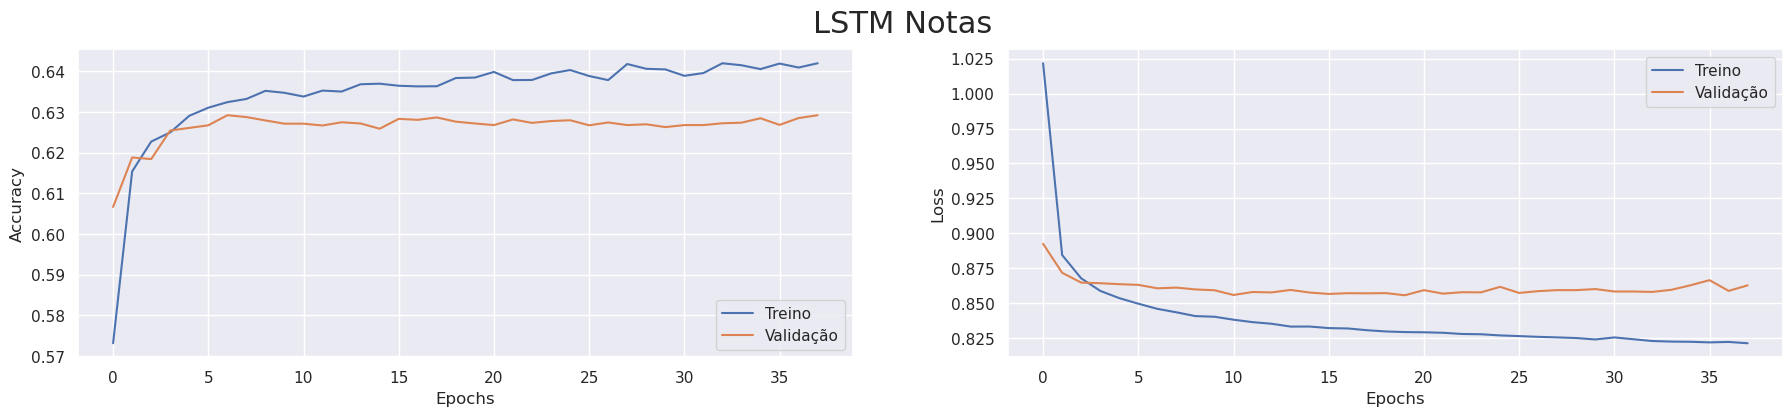

In [228]:
plot_history(history_LSTM_notas,"LSTM Notas")

In [229]:
lstm_notas.evaluate(x_LSTM_teste_numerico,y_teste_notas)

506/506 [==============================] - 3s 3ms/step - loss: 0.8877 - accuracy: 0.6195


[0.8876920342445374, 0.6195007562637329]

In [230]:
y_teste_lstm_notas_pred=lstm_notas.predict(x_LSTM_teste_numerico)

506/506 [==============================] - 2s 3ms/step


In [231]:
cm_lstm_notas=confusion_matrix(np.argmax(y_teste_notas,axis=1)+1,np.argmax(y_teste_lstm_notas_pred,axis=1)+1)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 1400x2200 with 0 Axes>

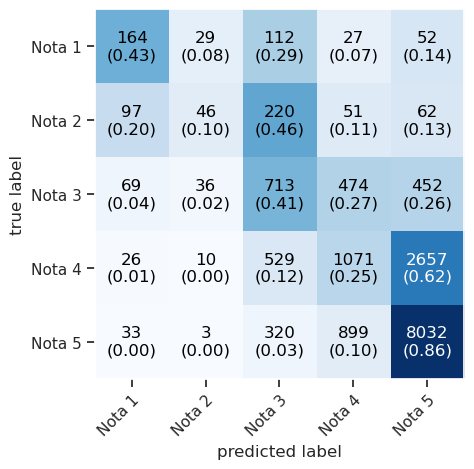

In [232]:
plt.figure(figsize=(14,22))
classes=["Nota 1","Nota 2","Nota 3","Nota 4","Nota 5"]
plot_confusion_matrix(conf_mat= cm_lstm_notas,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes)

## LSTM para classificar comentários como positivos, negativos ou neutros

Lstm para classificação dos comentários como positivos, negativos ou neutros

- y_treino_ternario              
- y_treino_ternario_undersampled 
- y_val_ternario                 
- y_teste_ternario               

In [233]:
y_treino_ternario              =np.load('../ternario/y_treino_ternario.npy')              
y_treino_ternario_undersampled =np.load('../ternario/y_treino_ternario_undersampled.npy')   
y_val_ternario                 =np.load('../ternario/y_val_ternario.npy')                  
y_teste_ternario               =np.load('../ternario/y_teste_ternario.npy')                 

In [234]:
#Treinar modelo
train_LSTM_ternaria =False
salvar_LSTM_ternaria=False

neurons_list        =[1,1,1]
embedding_size=100
sequence_lengh=np.shape(x_LSTM_treino_numerico)[1]
num_words_vocab=len(vocab_LSTM)
n_outputs=3
name='LSTM_ternaria'
dropout_rate=0.4


if train_LSTM_ternaria:
    callback=EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True) #Early stopping
    batch_size=32
    epochs=200

    lstm_ternaria=criar_LSTM(neurons=neurons_list,embedding_size=embedding_size,sequence_length=sequence_lengh,num_words_vocab=num_words_vocab,n_outputs=n_outputs,name=name)
    history_LSTM_ternaria=lstm_ternaria.fit(x=x_LSTM_treino_numerico,y=y_treino_ternario,
                        batch_size=batch_size,epochs=epochs,validation_data=[x_LSTM_val_numerico,y_val_ternario],callbacks=[callback])
    if salvar_LSTM_ternaria:
        lstm_ternaria.save('../models/LSTM_ternaria.keras')
        history_LSTM_ternaria=pd.DataFrame(history_LSTM_ternaria.history)
        history_LSTM_ternaria.to_pickle('../models/history_LSTM_ternaria.pkl')
    
else:
    lstm_ternaria=load_model('../models/LSTM_ternaria.keras',safe_mode=False)
    history_LSTM_ternaria=pd.read_pickle('../models/history_LSTM_ternaria.pkl')

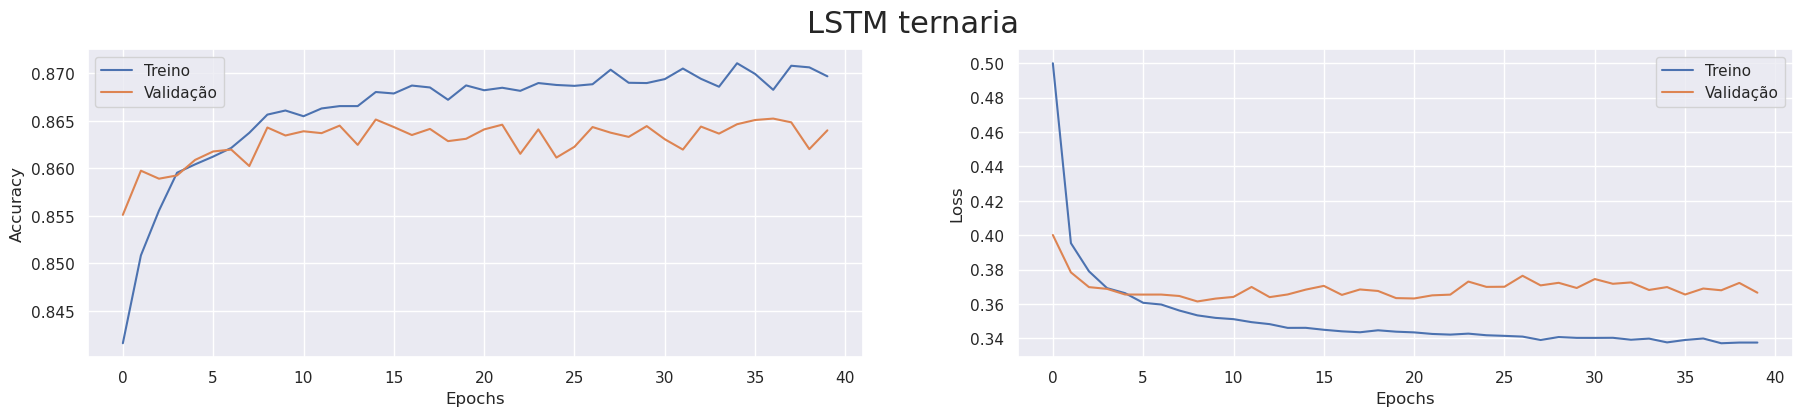

In [235]:
plot_history(history_LSTM_ternaria,'LSTM ternaria')

506/506 [==============================] - 2s 2ms/step


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 1400x2200 with 0 Axes>

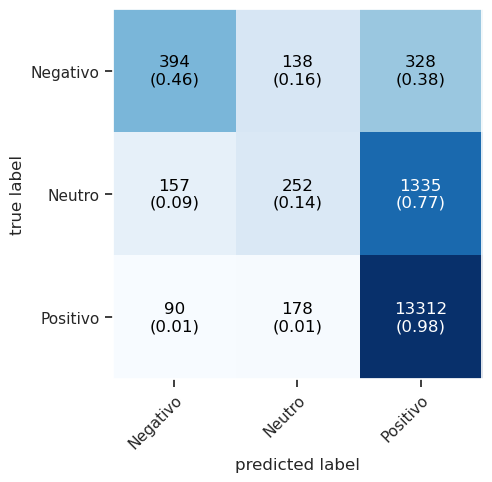

In [236]:
y_teste_lstm_ternaria_pred=lstm_ternaria.predict(x_LSTM_teste_numerico)
cm_lstm_ternaria=confusion_matrix(np.argmax(y_teste_ternario,axis=1)+1,np.argmax(y_teste_ternaria_pred,axis=1)+1)
plt.figure(figsize=(14,22))
classes=["Negativo","Neutro","Positivo"]
plot_confusion_matrix(conf_mat= cm_lstm_ternaria,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes)

## LSTM para classificar comentários como positivos ou neutros

Lstm para classificação dos comentários como positivos ou negativos

- y_treino_binario              
- y_treino_binario_undersampled 
- y_val_binario                
- y_teste_binario

In [237]:
y_treino_binario              =np.load('../binario/y_treino_binario.npy')              
y_treino_binario_undersampled =np.load('../binario/y_treino_binario_undersampled.npy')   
y_val_binario                 =np.load('../binario/y_val_binario.npy')                  
y_teste_binario               =np.load('../binario/y_teste_binario.npy')

In [240]:
#Treinar modelo
train_LSTM_binaria =True
salvar_LSTM_binaria=False

neurons_list        =[1,1,1]
embedding_size=100
sequence_lengh=np.shape(x_LSTM_treino_numerico)[1]
num_words_vocab=len(vocab_LSTM)
n_outputs=2
name='LSTM_binaria'
dropout_rate=0.4


if train_LSTM_binaria:
    callback=EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True) #Early stopping
    batch_size=32
    epochs=200

    lstm_binaria=criar_LSTM(neurons=neurons_list,embedding_size=embedding_size,sequence_length=sequence_lengh,num_words_vocab=num_words_vocab,n_outputs=n_outputs,name=name)
    history_LSTM_binaria=lstm_binaria.fit(x=x_LSTM_treino_undersampled_numerico,y=y_treino_binario_undersampled,
                        batch_size=batch_size,epochs=epochs,validation_data=[x_LSTM_val_numerico,y_val_binario],callbacks=[callback])
    history_LSTM_binaria=pd.DataFrame(history_LSTM_binaria.history)

    if salvar_LSTM_binaria:
        lstm_binaria.save('../models/LSTM_binaria.keras')
        history_LSTM_binaria.to_pickle('../models/history_LSTM_binaria.pkl')
    
else:
    lstm_binaria       =load_model('../models/LSTM_binaria.keras',safe_mode=False)
    history_LSTM_binaria=pd.read_pickle('../models/history_LSTM_binaria.pkl')

Epoch 1/200
240/240 [==============================] - 12s 26ms/step - loss: 0.6059 - accuracy: 0.7211 - val_loss: 0.3324 - val_accuracy: 0.9222
Epoch 2/200
240/240 [==============================] - 5s 21ms/step - loss: 0.4495 - accuracy: 0.8217 - val_loss: 0.2635 - val_accuracy: 0.9127
Epoch 3/200
240/240 [==============================] - 5s 20ms/step - loss: 0.3973 - accuracy: 0.8431 - val_loss: 0.2902 - val_accuracy: 0.8936
Epoch 4/200
240/240 [==============================] - 5s 20ms/step - loss: 0.3751 - accuracy: 0.8552 - val_loss: 0.2991 - val_accuracy: 0.8771
Epoch 5/200
240/240 [==============================] - 5s 21ms/step - loss: 0.3558 - accuracy: 0.8646 - val_loss: 0.2497 - val_accuracy: 0.9101
Epoch 6/200
240/240 [==============================] - 5s 20ms/step - loss: 0.3411 - accuracy: 0.8677 - val_loss: 0.2447 - val_accuracy: 0.9122
Epoch 7/200
240/240 [==============================] - 5s 21ms/step - loss: 0.3315 - accuracy: 0.8760 - val_loss: 0.2699 - val_accuracy

TypeError: 'History' object is not subscriptable

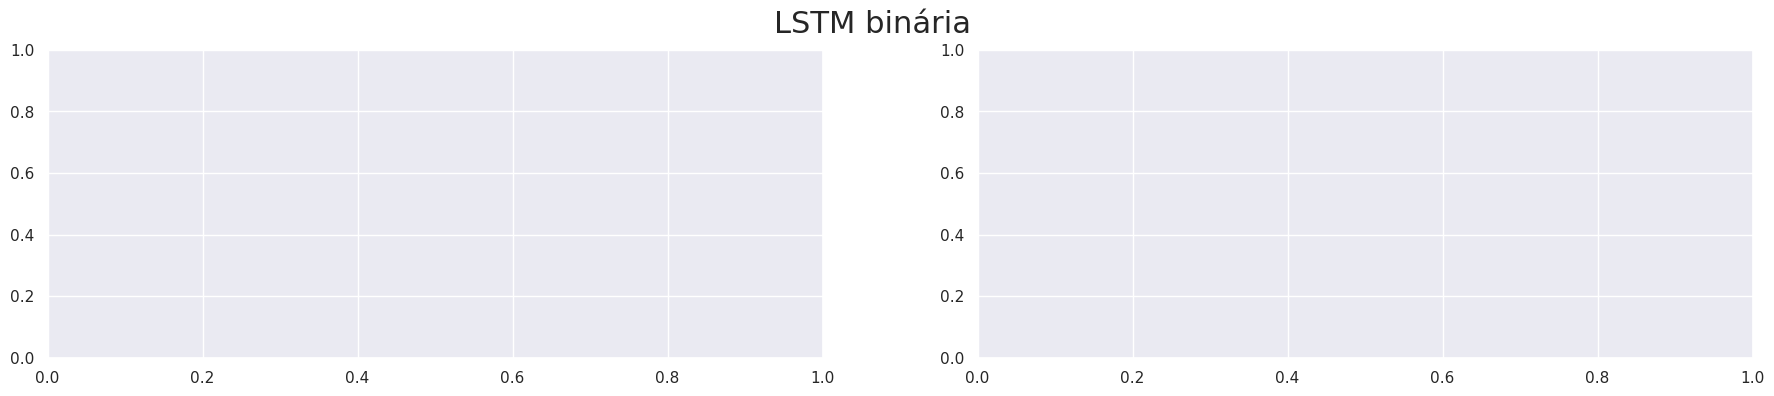

In [243]:
plot_history(history_LSTM_binaria,'LSTM binária')

  1/506 [..............................] - ETA: 9s

506/506 [==============================] - 2s 3ms/step


(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

<Figure size 1400x2200 with 0 Axes>

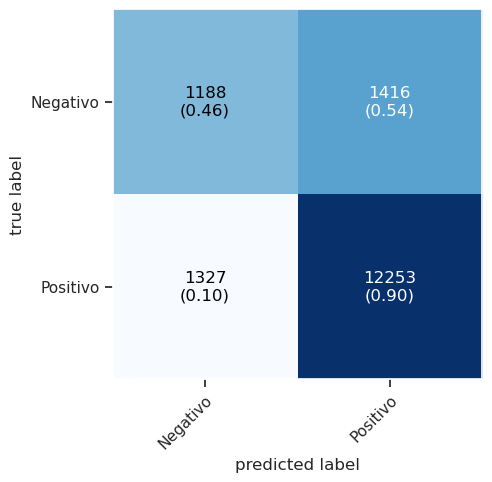

In [242]:
y_teste_lstm_binaria_pred=lstm_binaria.predict(x_LSTM_teste_numerico)
cm_lstm_binaria=confusion_matrix(np.argmax(y_teste_binario,axis=1)+1,np.argmax(y_teste_lstm_binaria_pred,axis=1)+1)
plt.figure(figsize=(14,22))
classes=["Negativo","Positivo"]
plot_confusion_matrix(conf_mat= cm_lstm_binaria,
                                colorbar=False,
                                show_absolute=True,
                                show_normed=True,
                                class_names=classes)